<a href="https://colab.research.google.com/github/DrMohamedElsherif/Neuromatch-fMRI-AnalysisProject/blob/main/Neuromatch_Own_Project_Work_Decoding_and_Analyzing_Emotional_Brain_Activity_Patterns_from_fMRI_HCP_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Comparative Analysis of SVM and custom-designed GCN Models for Decoding Emotional Brain Activity Patterns from fMRI Data: Insights from the HCP Dataset**

### **HCP Data Loading and Directory Set Up**

In [7]:
# @title Install all required dependencies
!pip install seaborn --quiet
!pip install nilearn --quiet

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import plotting, datasets

# Library for brain activity comparative analysis across ROI and networks
from scipy.stats import ttest_rel

# Libraries for the SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Libraries for the GCN
!pip install torch_geometric scikit-learn --quiet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

# Libraries for evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

In [ ]:
# Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# @title Download the HCR data and Extract the data in `HCP_DIR`

import os, requests, tarfile

fname = "hcp_task.tgz"
url = "https://osf.io/s4h8j/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")

# @title Extract the data in `HCP_DIR`
fname_ex = "hcp_task"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")

regions = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

Download hcp_task.tgz completed!
Extracting hcp_task.tgz...


### **HELPER FUNCTIONS**

In [ ]:
def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = EXPERIMENTS[experiment]['runs'][run]
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment
    run (int) : 0-based run index, across all tasks

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           str(task_key), f"{cond}.txt")

    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames = [f for f in frames if np.max(f) < 176]  #removing the bug of dataset
    frames_list.append(frames)

  return frames_list

# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


### **EXAMPLE RUN ON THE EMOTION EXPERIMENT**

(360, 176)


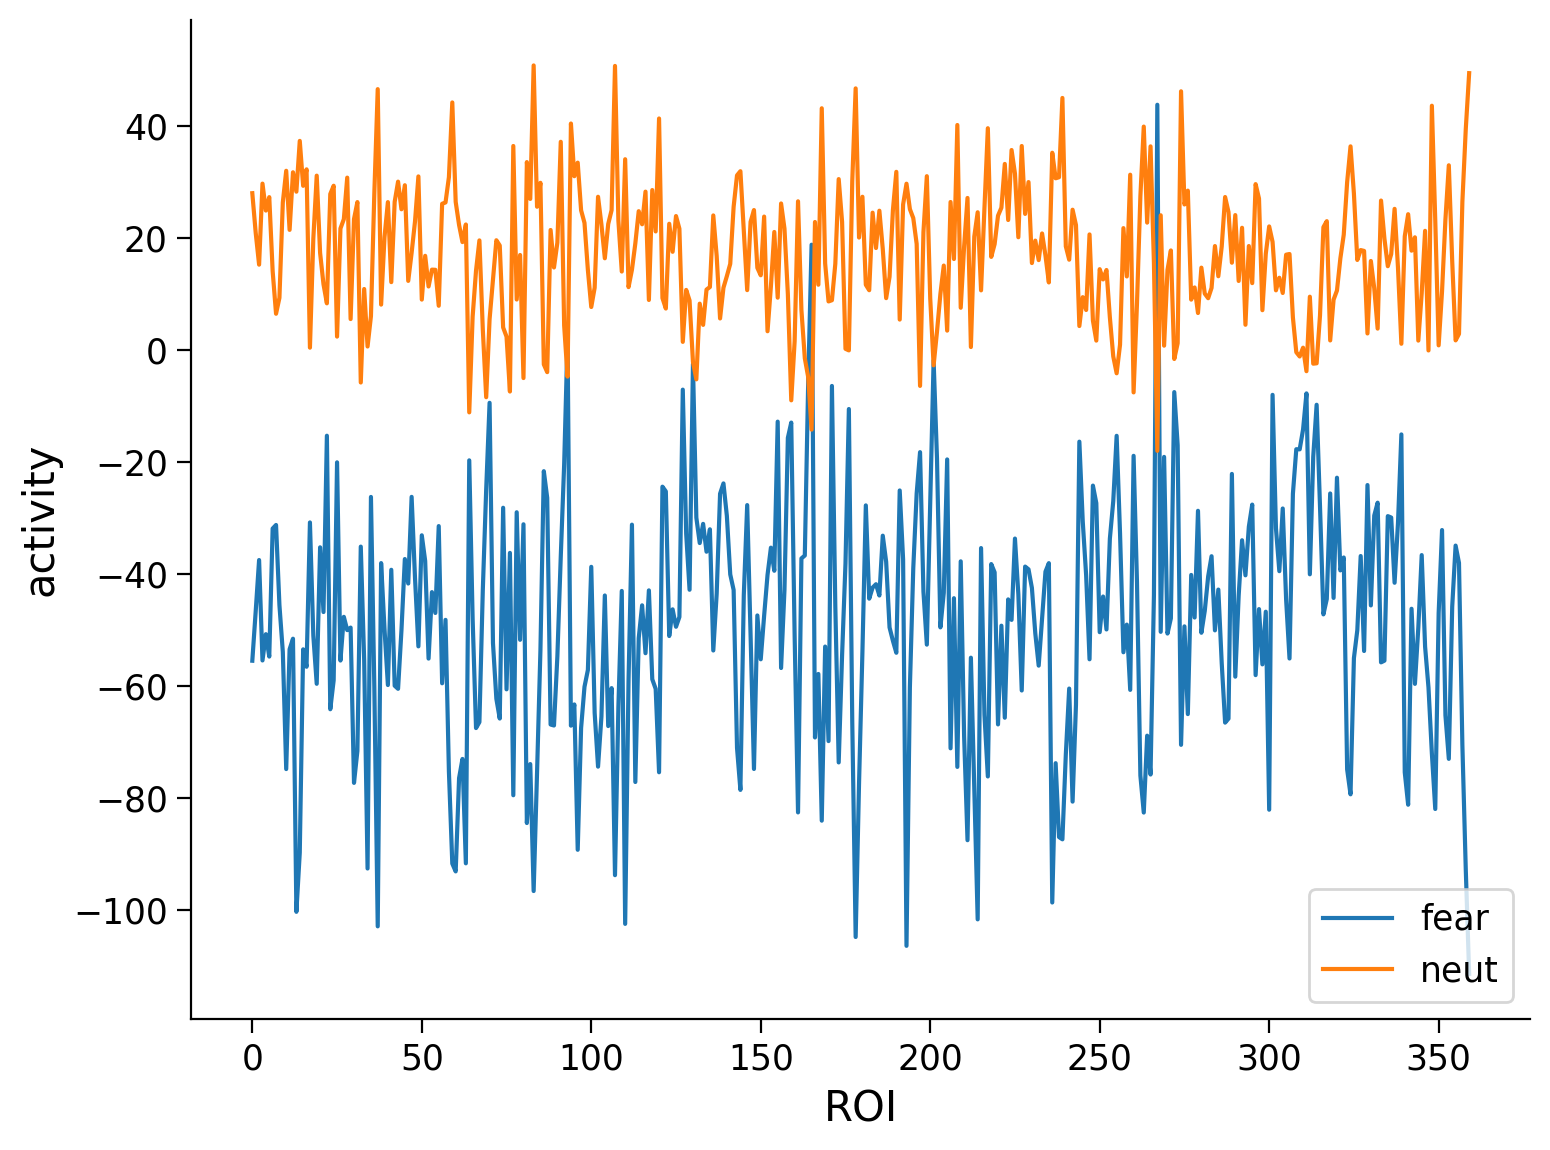

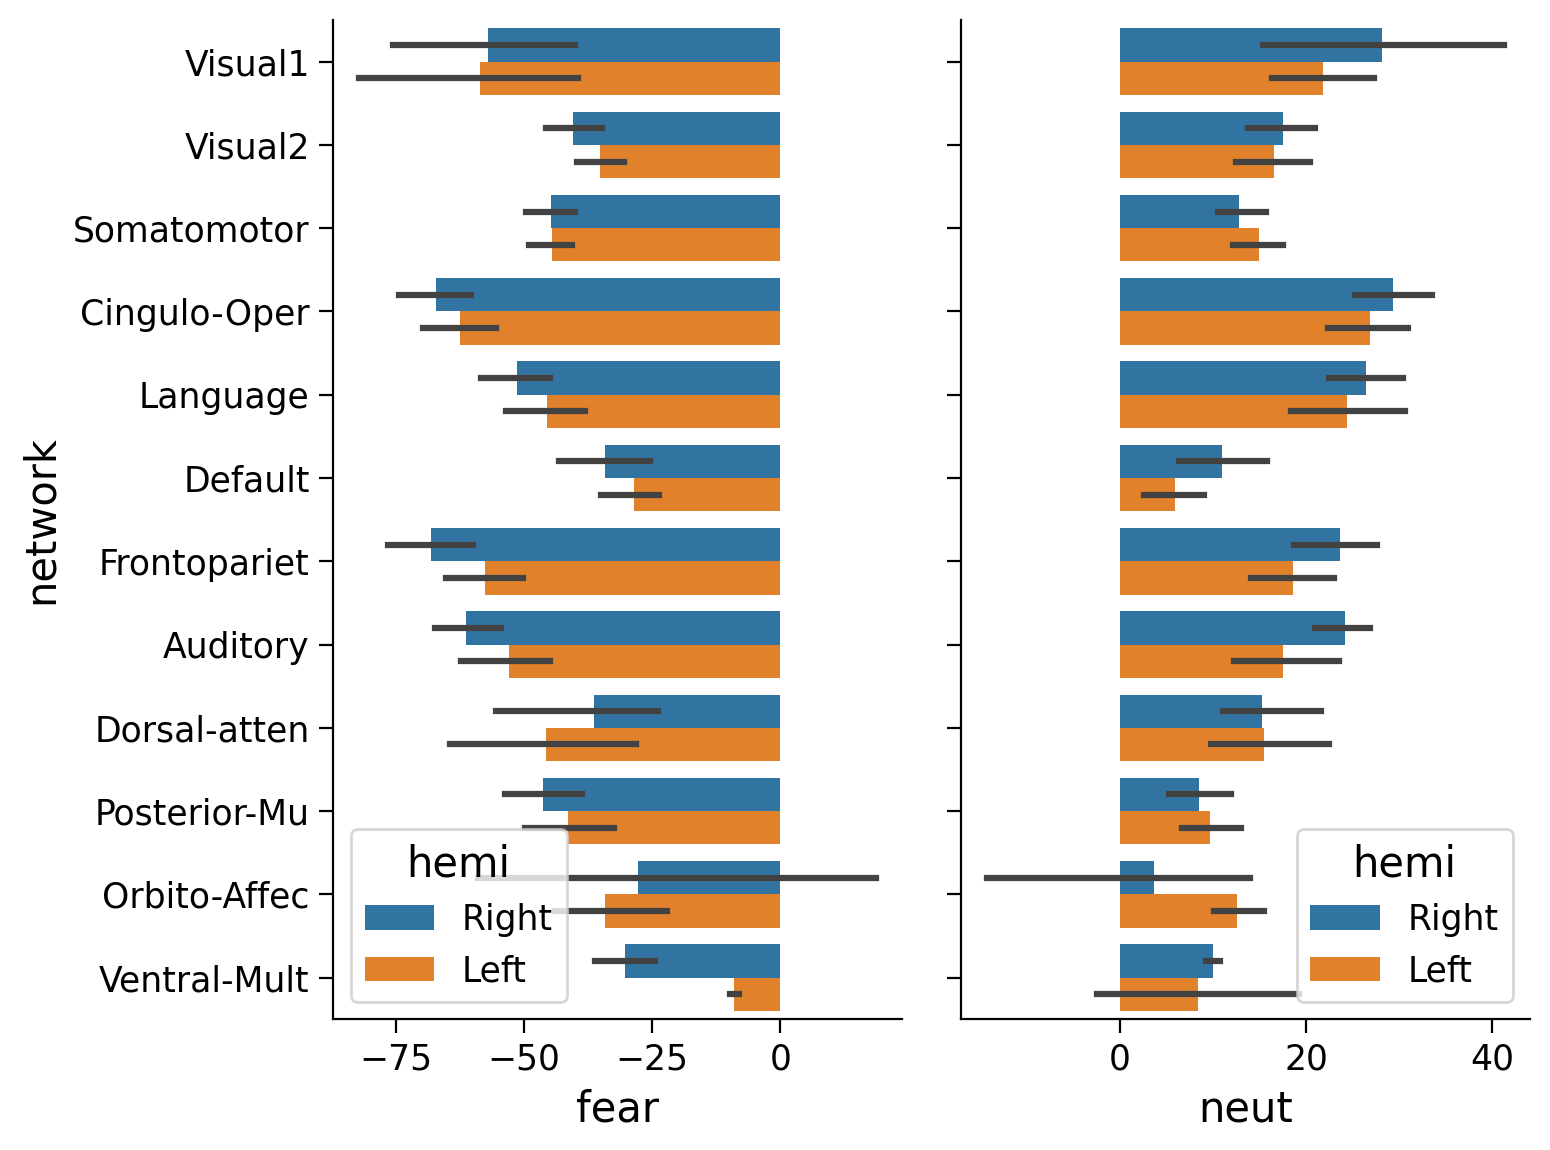

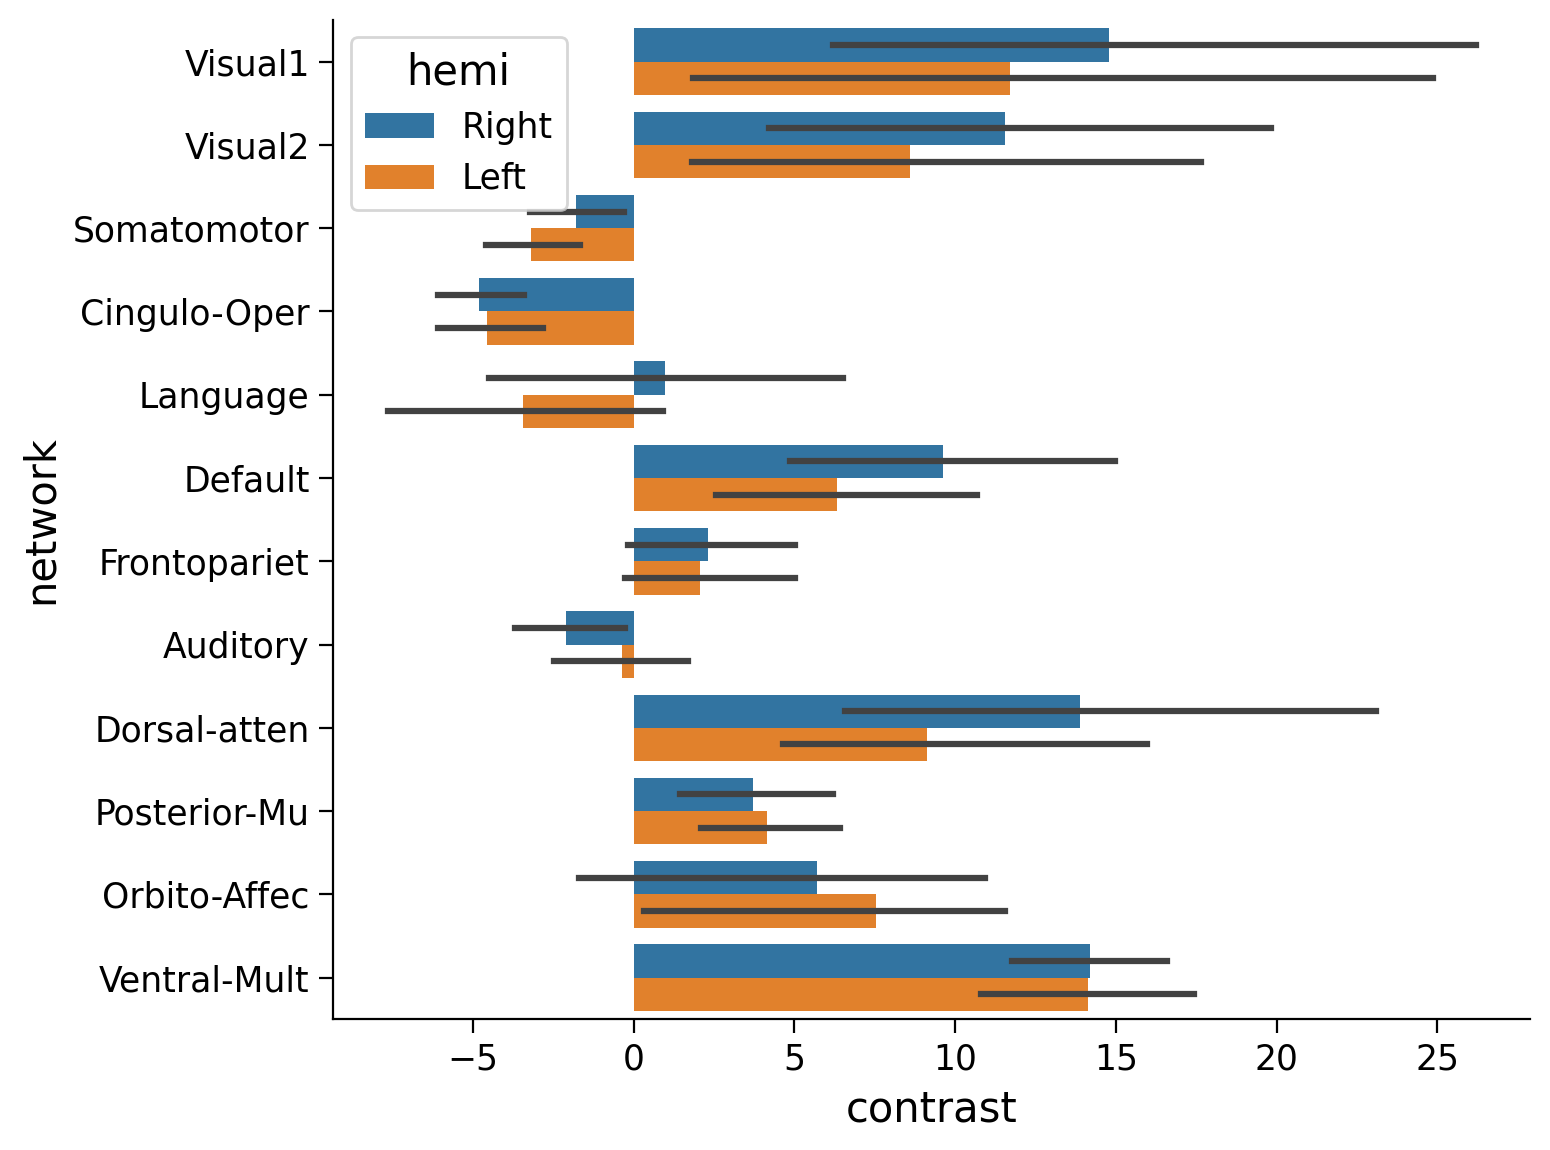

In [ ]:
my_exp = 'EMOTION'
my_subj = 0
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              dir=os.path.join(HCP_DIR, "hcp_task"),
                              remove_mean=True)
print(data.shape)

evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run, dir=os.path.join(HCP_DIR, "hcp_task"))

avg_activity_fear= average_frames(data, evs, my_exp, 'fear')
avg_activity_neutral= average_frames(data, evs, my_exp, 'neut')
contrast = avg_activity_fear - avg_activity_neutral  # difference between fear and neut

# Plot activity level in each ROI for both conditions
plt.figure()
plt.plot(avg_activity_fear, label='fear')
plt.plot(avg_activity_neutral, label='neut')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

df = pd.DataFrame({'fear': avg_activity_fear,
                   'neut': avg_activity_neutral,
                   'network': region_info['network'],
                   'hemi': region_info['hemi']
                   })

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.barplot(y='network', x='fear', data=df, hue='hemi', ax=ax1)
sns.barplot(y='network', x='neut', data=df, hue='hemi', ax=ax2)
fig.show()


group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp, run=r,
                                  dir=os.path.join(HCP_DIR, "hcp_task"),
                                  remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp, run=r,
                   dir=os.path.join(HCP_DIR, "hcp_task"))

    fear = average_frames(data, evs, my_exp, 'fear')
    neut = average_frames(data, evs, my_exp, 'neut')

    contrast = fear - neut
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

df = pd.DataFrame({'contrast': group_contrast,
                   'network': region_info['network'],
                   'hemi': region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

In [ ]:
# @title Download `atlas.npz`

import os, requests, tarfile

fname = "atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")

# This uses the nilearn package
with np.load(fname) as dobj:
  atlas = dict(**dobj)

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'], surf_contrast, vmax=20)

Download atlas.npz completed!


# **Analysis of ROI Activity and Significance across Emotional conditions**

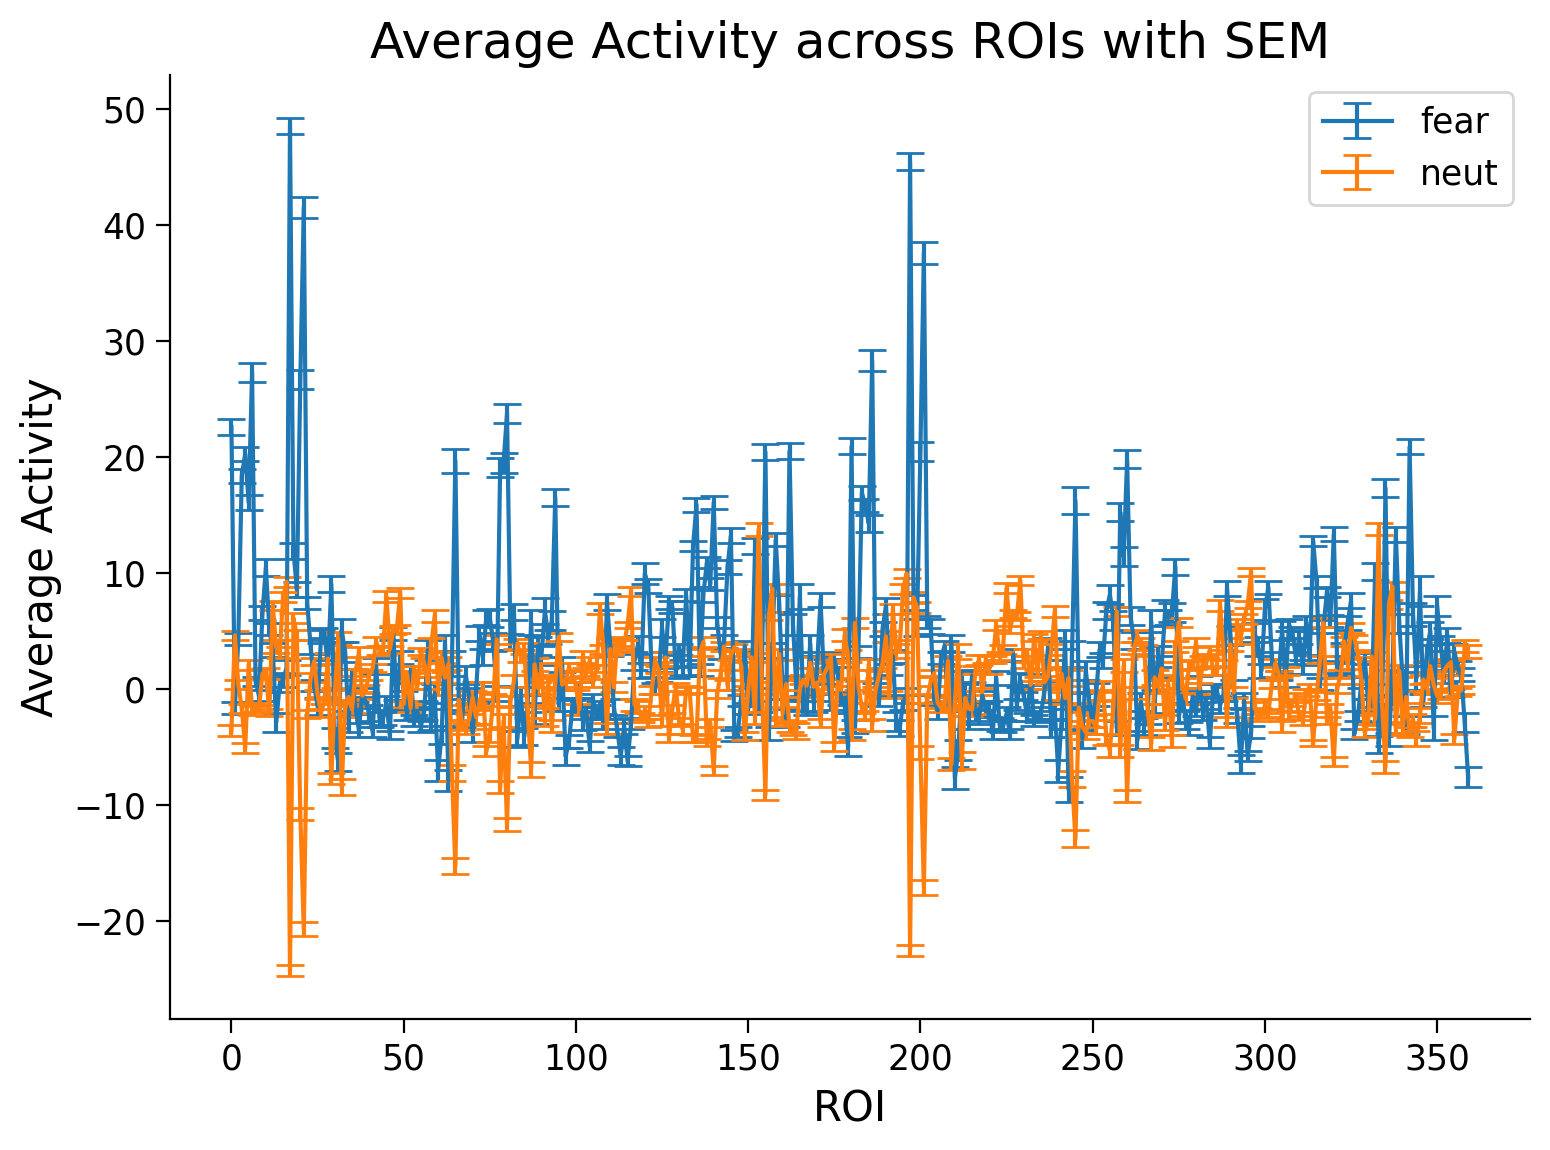

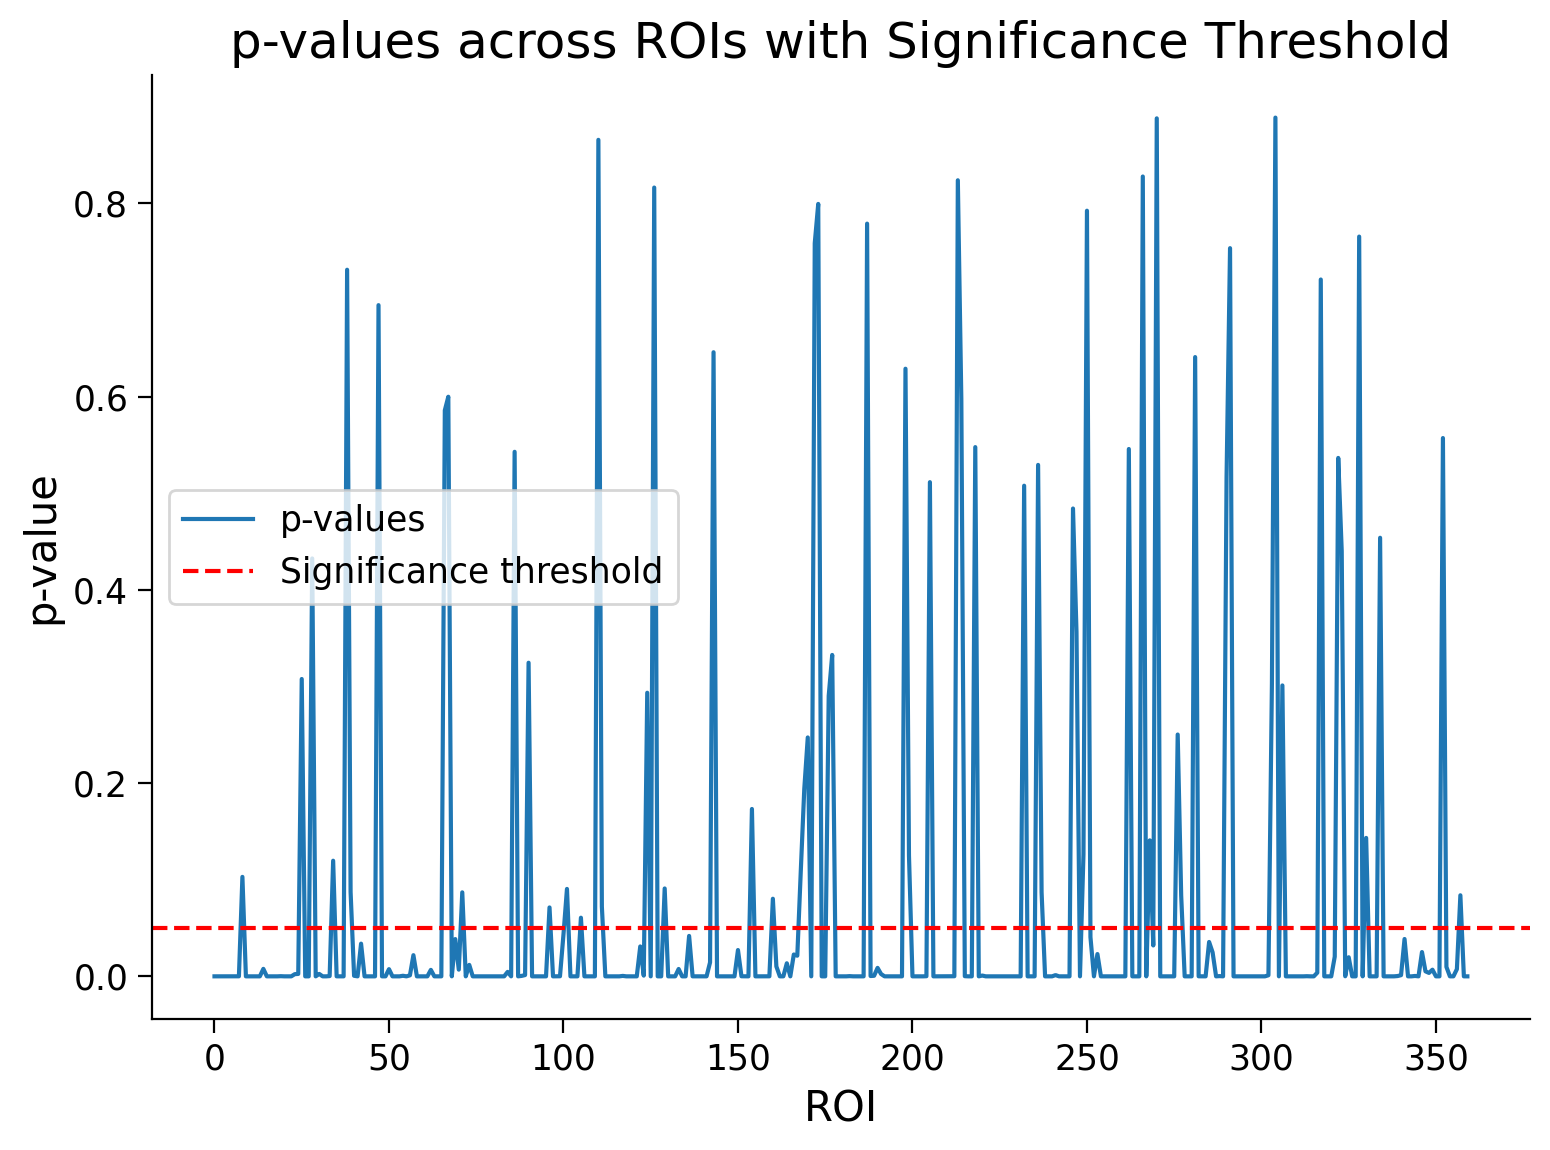

In [ ]:
# @title Conducting a Paired t-test (dependent samples t-test)
' The test evaluates whether there is a significant difference in the average ROI activity between our two conditions (fear and neut) for the same subjects.'

# Function to calculate SEM
def calculate_sem(data):
    return np.std(data, axis=0) / np.sqrt(data.shape[0])

# Enhanced plot with error bars
def plot_average_activity_with_sem(avg_activity, conditions):
    plt.figure()
    for condition in conditions:
        data = np.vstack(avg_activity[condition])
        avg = data.mean(axis=0)
        sem = calculate_sem(data)
        plt.errorbar(range(len(avg)), avg, yerr=sem, label=condition, capsize=5)

    plt.xlabel('ROI')
    plt.ylabel('Average Activity')
    plt.legend()
    plt.title('Average Activity across ROIs with SEM')
    plt.show()

# Enhanced comparison with p-value thresholding
def plot_p_values_with_threshold(p_values, threshold=0.05):
    plt.figure()
    plt.plot(p_values, label='p-values')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Significance threshold')
    plt.xlabel('ROI')
    plt.ylabel('p-value')
    plt.legend()
    plt.title('p-values across ROIs with Significance Threshold')
    plt.show()


# Parameters
experiment = 'EMOTION'
conditions = ['fear', 'neut']
data_dir = os.path.join(HCP_DIR, "hcp_task")

# Calculate average activity
avg_activity = {condition: [] for condition in conditions}

for subject in subjects:
    for run in [0, 1]:
        data = load_single_timeseries(subject=subject, experiment=experiment, run=run, dir=data_dir)
        evs = load_evs(subject=subject, experiment=experiment, run=run, dir=data_dir)
        for condition in conditions:
            avg_activity[condition].append(average_frames(data, evs, experiment, condition))

# Compare conditions
condition1_data = np.vstack(avg_activity[conditions[0]])
condition2_data = np.vstack(avg_activity[conditions[1]])
t_stat, p_values = ttest_rel(condition1_data, condition2_data, axis=0)

# Plot average activity with SEM
plot_average_activity_with_sem(avg_activity, conditions)

# Plot p-values with significance threshold
plot_p_values_with_threshold(p_values)

# Determine significant and non-significant networks
significance_threshold = 0.05
significant_networks = set(region_info['network'][i] for i in range(len(p_values)) if p_values[i] < significance_threshold)
non_significant_networks = set(region_info['network'][i] for i in range(len(p_values)) if p_values[i] >= significance_threshold)

# Create a DataFrame
df_significance = pd.DataFrame({
    'Significant Networks': pd.Series(list(significant_networks)),
    'Non-Significant Networks': pd.Series(list(non_significant_networks))
})

###### Based on the above results, The Default Network is both significant and non significant,
# which suggests that some ROI beloning to Default Netwrok are significant while others are not

# Create a detailed DataFrame with ROI names, networks, and p-values
roi_data = pd.DataFrame({
    'ROI': region_info['name'],
    'Network': region_info['network'],
    'p-value': p_values
})

# Add a significance column
roi_data['Significant'] = roi_data['p-value'] < significance_threshold

# Filter ROIs belonging to the Default network
default_network_rois = roi_data[roi_data['Network'] == 'Default']

In [ ]:
# Display the DataFrame
df_significance

Significant Networks Non-Significant Networks
0              Language                 Language
1          Posterior-Mu             Posterior-Mu
2          Ventral-Mult             Cingulo-Oper
3          Cingulo-Oper              Somatomotor
4           Somatomotor                 Auditory
5              Auditory             Frontopariet
6          Frontopariet                  Default
7          Dorsal-atten                  Visual2
8               Visual1             Orbito-Affec
9               Default                      NaN
10              Visual2                      NaN
11         Orbito-Affec                      NaN

In [ ]:
# Display the Default network ROIs with their significance status
default_network_rois

ROI  Network        p-value  Significant
11     R_55b  Default   1.399965e-19         True
24     R_PSL  Default   2.505048e-03         True
25     R_SFL  Default   3.077143e-01        False
27     R_STV  Default   2.528720e-19         True
73      R_44  Default   1.186568e-02         True
74      R_45  Default   6.118197e-30         True
78    R_IFJa  Default   3.880601e-88         True
80    R_IFSp  Default  3.572293e-124         True
122   R_STGa  Default   3.094135e-02         True
124     R_A5  Default   2.934768e-01        False
127  R_STSda  Default   1.056774e-41         True
128  R_STSdp  Default   2.441845e-29         True
138  R_TPOJ1  Default   3.093676e-84         True
171    R_TGv  Default   5.562188e-34         True
191    L_55b  Default   2.413679e-03         True
205    L_SFL  Default   5.114251e-01        False
254     L_45  Default   1.382926e-25         True
258   L_IFJa  Default   1.431767e-55         True
302   L_STGa  Default   1.111469e-03         True
304     L_A5  Default   8.886848e-01        False
308  L_STSdp  Default   1.070934e-16         True
318  L_TPOJ1  Default   4.801378e-47         True
351    L_TGv  Default   2.713257e-07         True

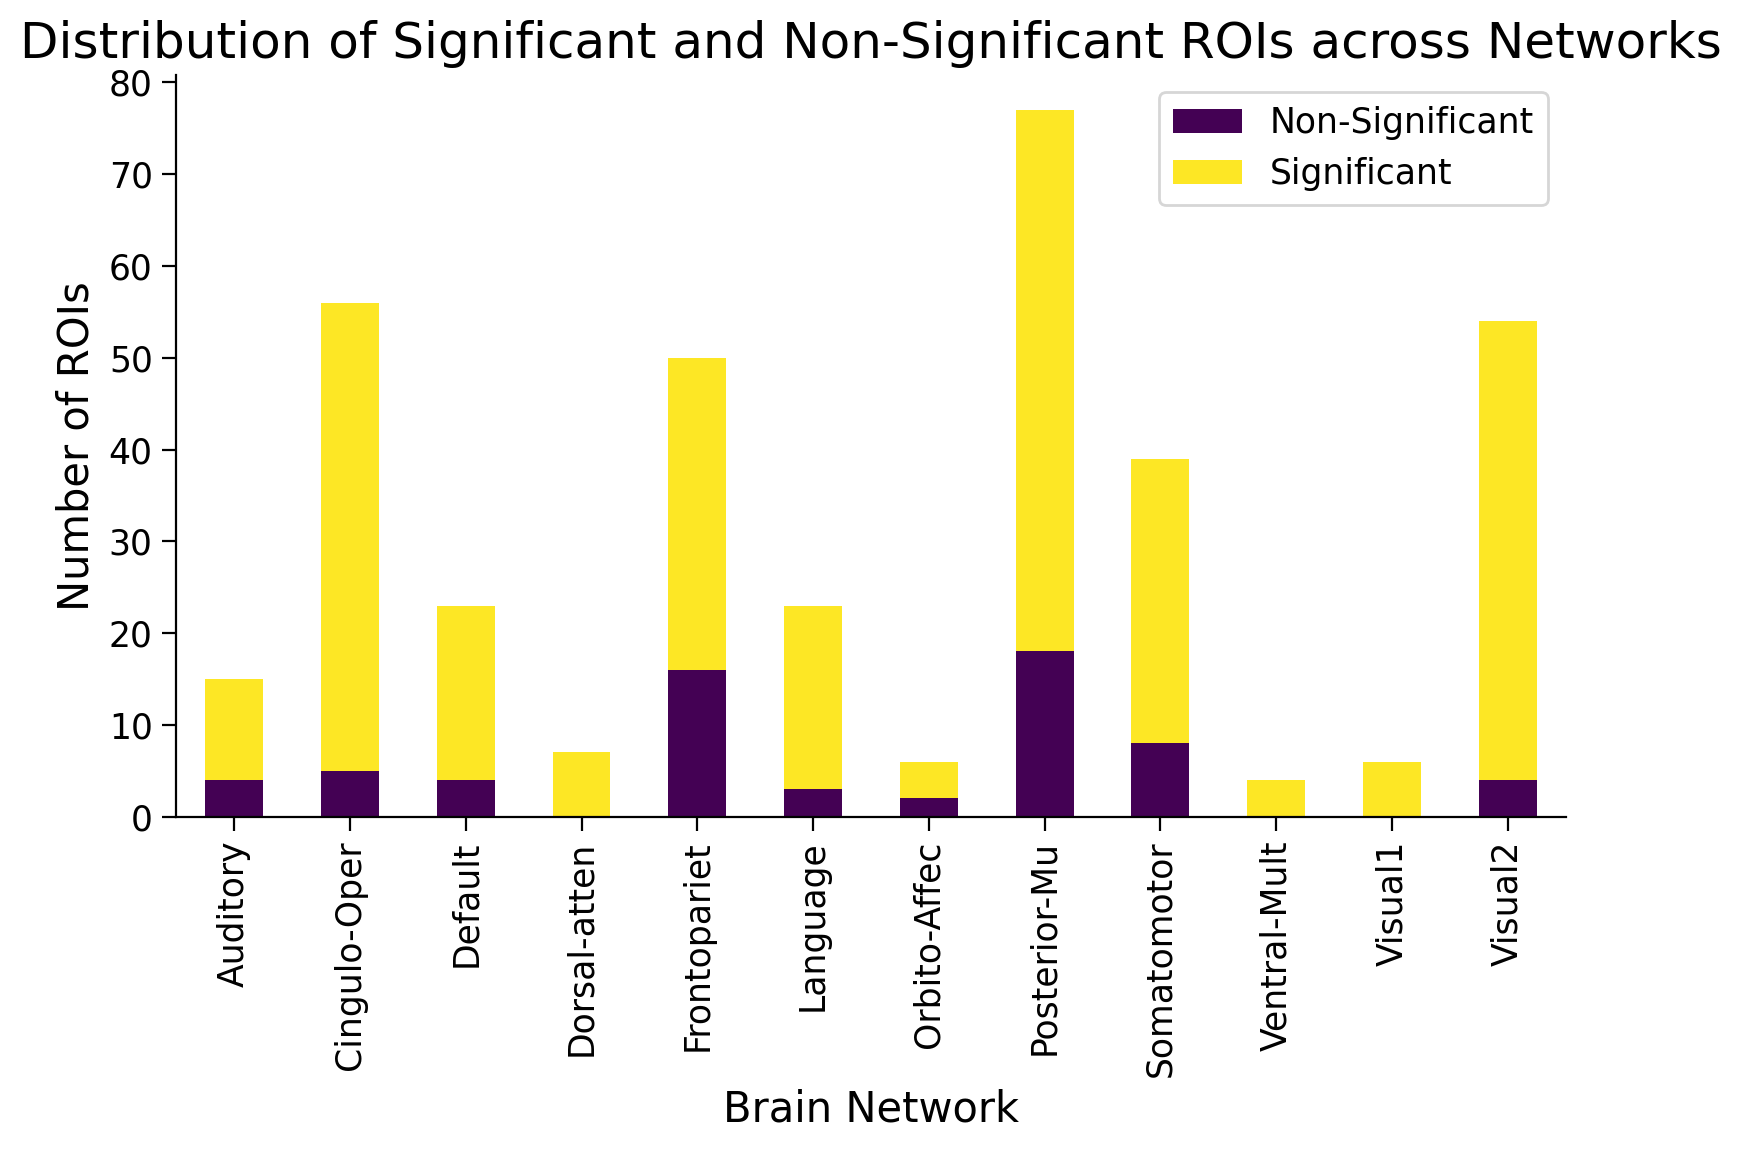

In [ ]:
# Create a boolean mask for significance based on p-value threshold
significant_mask = p_values < significance_threshold

# Create a DataFrame to summarize the p-values and significance
roi_data = pd.DataFrame({
    'ROI': region_info['name'],
    'Network': region_info['network'],
    'p-value': p_values,
    'Significant': significant_mask
})

# Aggregate the number of significant and non-significant ROIs per network
network_summary = roi_data.groupby(['Network', 'Significant']).size().unstack(fill_value=0)

# Plot the results
network_summary.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Brain Network')
plt.ylabel('Number of ROIs')
plt.title('Distribution of Significant and Non-Significant ROIs across Networks')
plt.legend(['Non-Significant', 'Significant'])
plt.show()


In [ ]:
# @title Interactive Plot to ROIs (and their related Networks) and their P-value

import plotly.express as px

# Prepare the data for Plotly
roi_data['Sig'] = roi_data['Significant'].apply(lambda x: 'Significant' if x else 'Non-Significant')

# Interactive scatter plot
fig = px.scatter(
    roi_data,
    x='ROI',
    y='p-value',
    color='Sig',
    hover_data=['Network'],
    title='<b>Significant and Non-Significant ROIs</b>',  # Making the title bold
    labels={'p-value': 'P-Value'}
)

# Add significance threshold line
fig.add_hline(y=significance_threshold, line_dash="dash", line_color="red", annotation_text="Threshold")

# Show the plot
fig.show()

Top contributing ROIs for Fear condition:
       ROI  Network  Mean Activity (Fear)  Mean Activity (Neut)
17   R_FFC  Visual2             48.512728            -24.329338
197  L_FFC  Visual2             45.429372            -22.588077
21   R_PIT  Visual2             41.492575            -20.746342
201  L_PIT  Visual2             37.548257            -17.159148
186   L_V8  Visual2             28.282026             -3.142413

Top contributing ROIs for Neut condition:
        ROI   Network  Mean Activity (Fear)  Mean Activity (Neut)
333  L_VMV3   Visual2             -4.824021             13.738156
153  R_VMV3   Visual2             -1.242898             13.704108
296   L_AIP  Language             -3.726751             10.057542
196  L_IPS1   Visual2             -0.600132              9.925035
229   L_MIP  Language              0.722604              9.316717


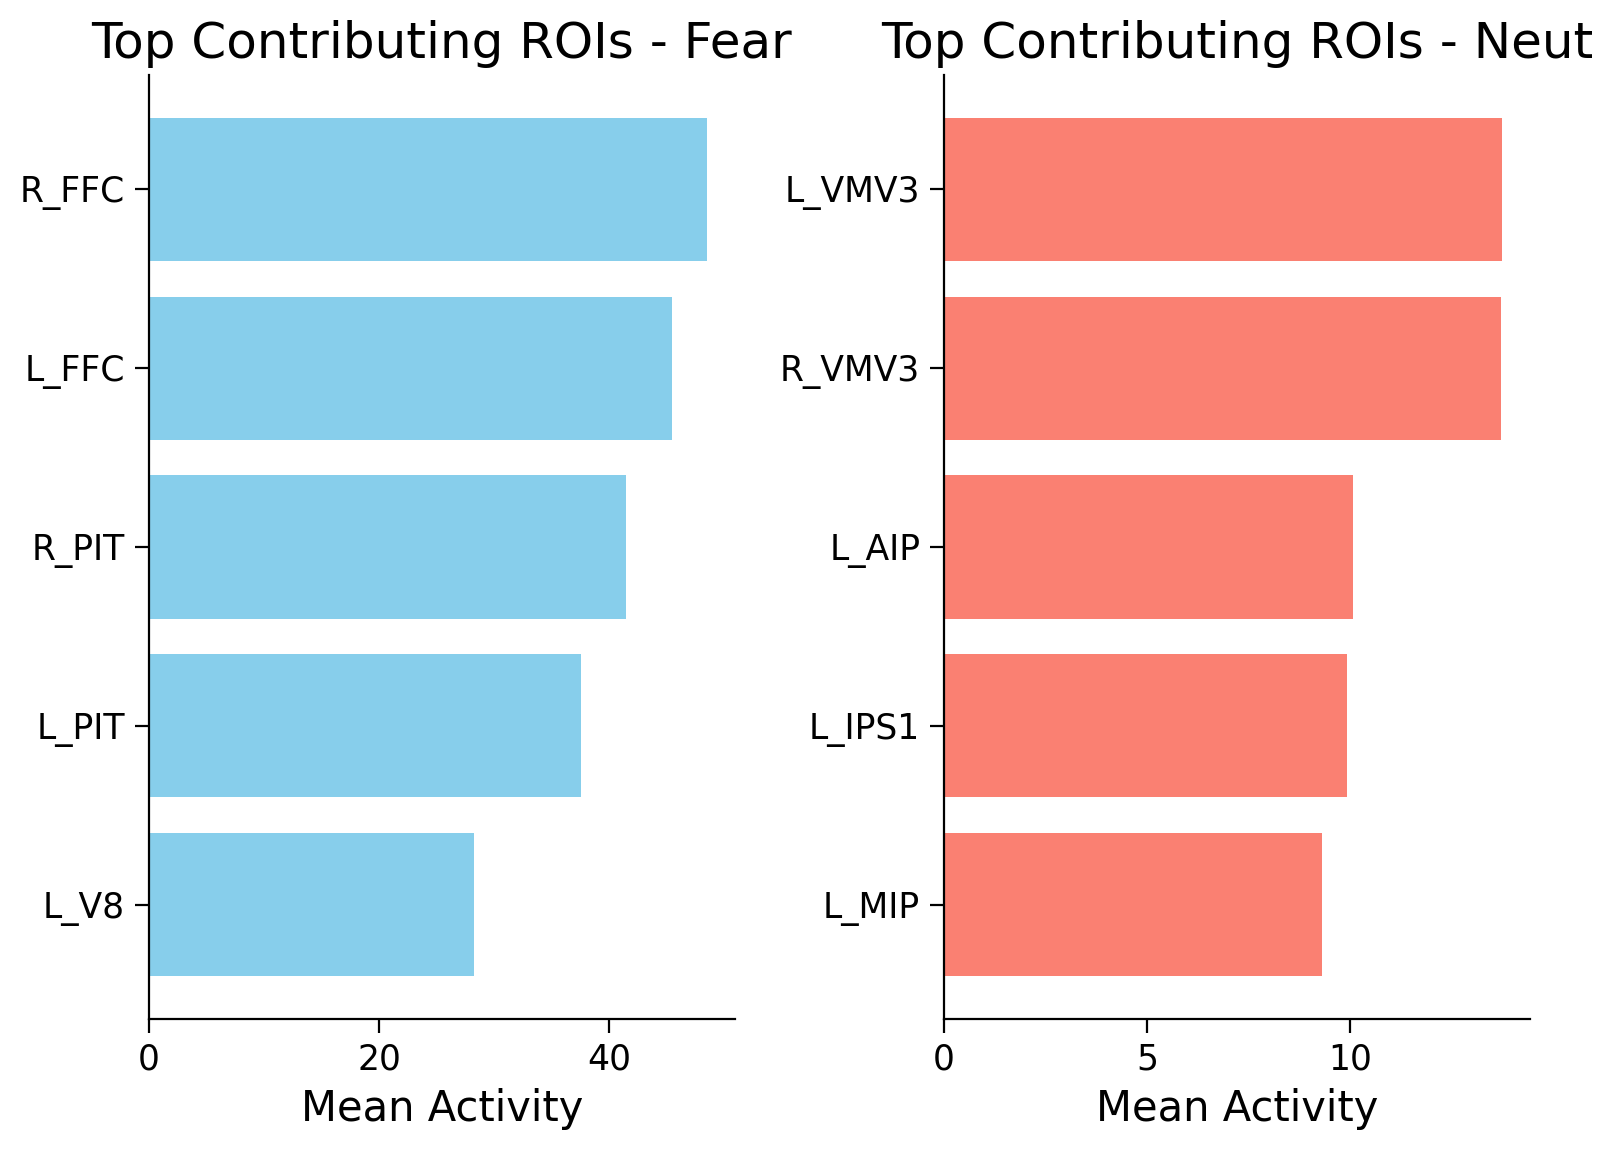

In [ ]:
# Calculate mean activity for each ROI
mean_activity_fear = condition1_data.mean(axis=0)
mean_activity_neut = condition2_data.mean(axis=0)

# Create a DataFrame with mean activities
mean_activity_df = pd.DataFrame({
    'ROI': region_info['name'],
    'Network': region_info['network'],
    'Mean Activity (Fear)': mean_activity_fear,
    'Mean Activity (Neut)': mean_activity_neut
})

# Identify ROIs with the highest mean activity for each condition
top_contributing_rois_fear = mean_activity_df.nlargest(5, 'Mean Activity (Fear)')
top_contributing_rois_neut = mean_activity_df.nlargest(5, 'Mean Activity (Neut)')

# Display top contributing ROIs
print("Top contributing ROIs for Fear condition:")
print(top_contributing_rois_fear)
print("\nTop contributing ROIs for Neut condition:")
print(top_contributing_rois_neut)

# Visualize the results
def plot_top_contributing_rois(mean_activity_df, top_n=5):
    top_fear = mean_activity_df.nlargest(top_n, 'Mean Activity (Fear)')
    top_neut = mean_activity_df.nlargest(top_n, 'Mean Activity (Neut)')

    fig, axes = plt.subplots(1, 2, figsize=(8, 6))

    axes[0].barh(top_fear['ROI'], top_fear['Mean Activity (Fear)'], color='skyblue')
    axes[0].set_title('Top Contributing ROIs - Fear')
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Mean Activity')

    axes[1].barh(top_neut['ROI'], top_neut['Mean Activity (Neut)'], color='salmon')
    axes[1].set_title('Top Contributing ROIs - Neut')
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Mean Activity')

    plt.tight_layout()
    plt.show()

plot_top_contributing_rois(mean_activity_df)

Top contributing networks for Fear condition:
Network
Visual2    5
Name: count, dtype: int64

Top contributing networks for Neut condition:
Network
Visual2     3
Language    2
Name: count, dtype: int64


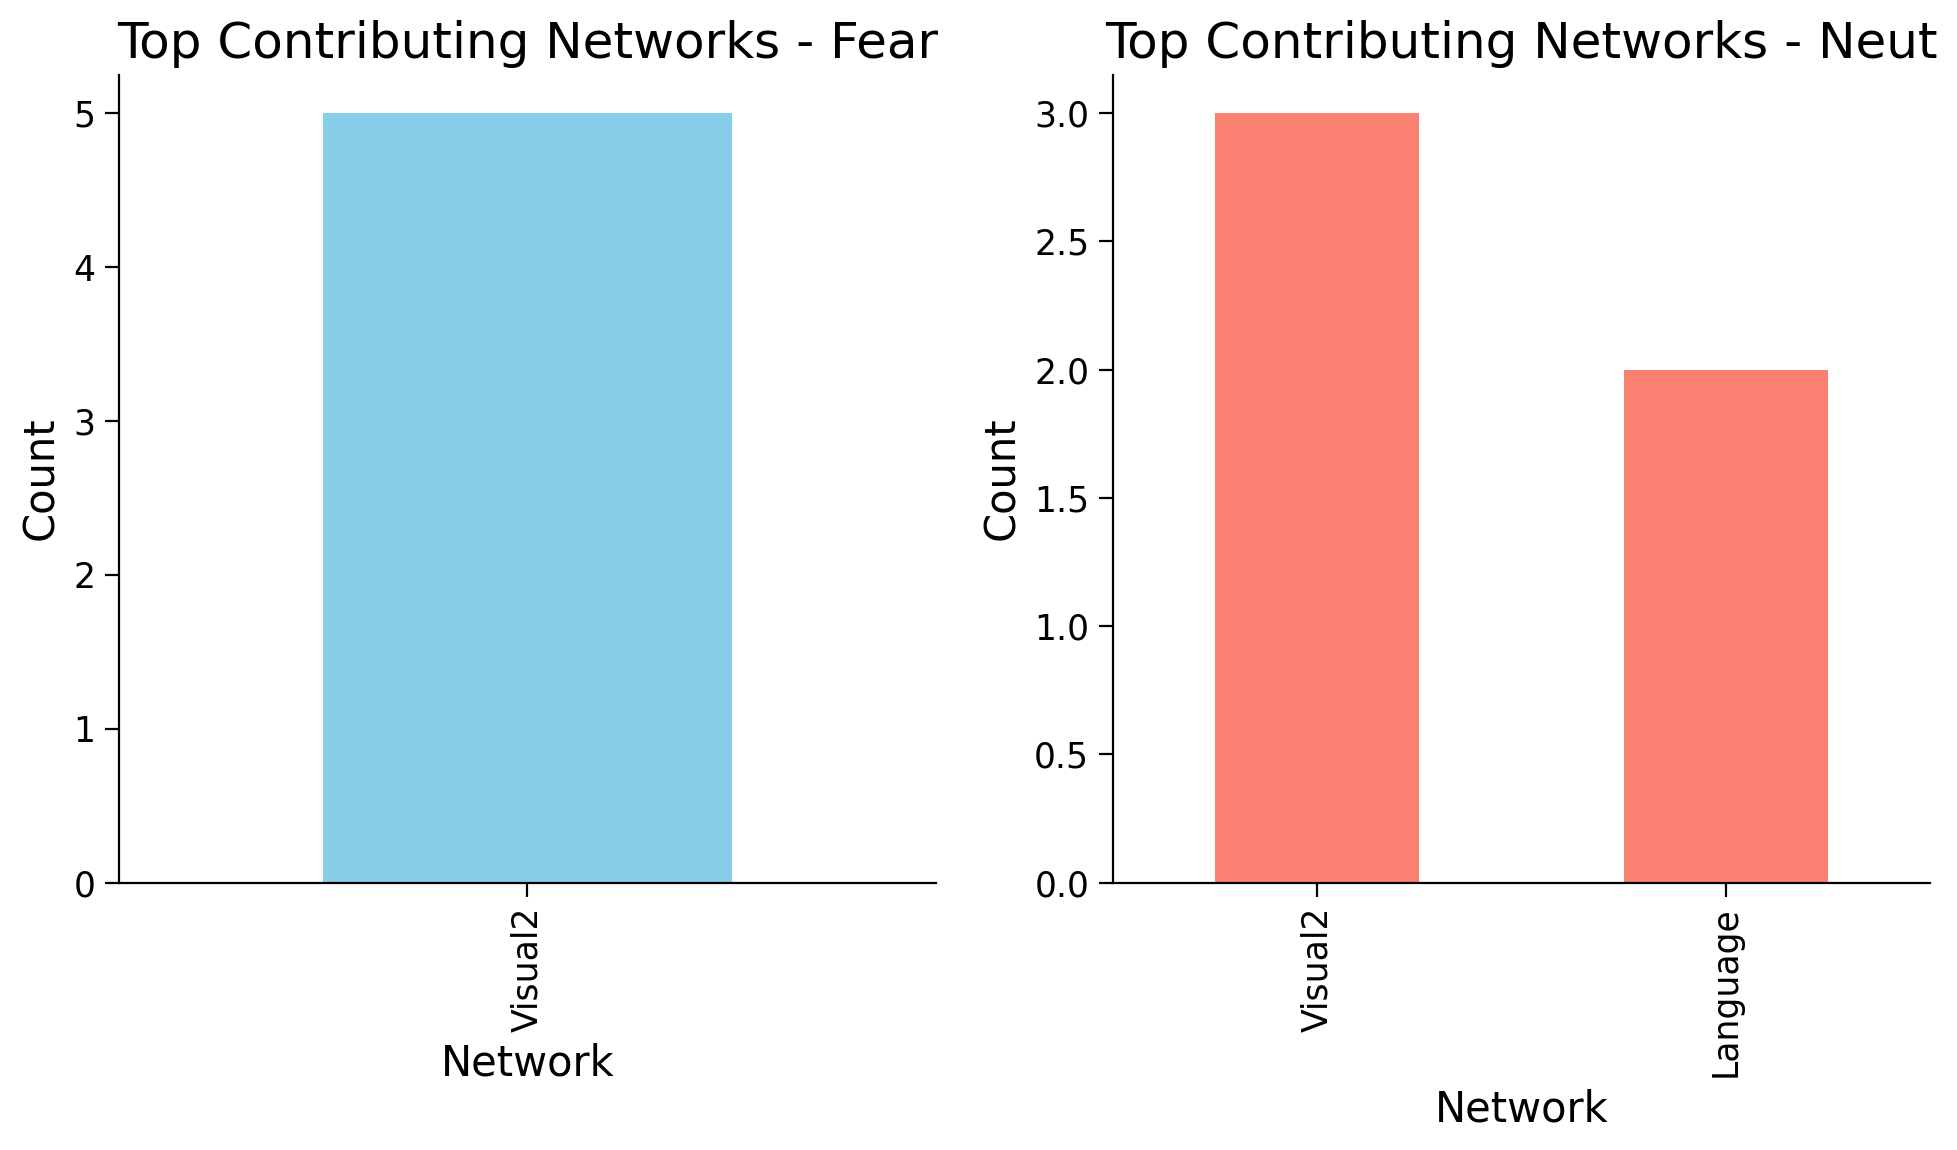

In [ ]:
# Calculate the frequency of each network among the top contributing ROIs
top_networks_fear = top_contributing_rois_fear['Network'].value_counts()
top_networks_neut = top_contributing_rois_neut['Network'].value_counts()

# Display the top contributing networks
print("Top contributing networks for Fear condition:")
print(top_networks_fear)
print("\nTop contributing networks for Neut condition:")
print(top_networks_neut)

# Visualize the top contributing networks
def plot_top_contributing_networks(top_networks_fear, top_networks_neut):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    top_networks_fear.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Top Contributing Networks - Fear')
    axes[0].set_xlabel('Network')
    axes[0].set_ylabel('Count')

    top_networks_neut.plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title('Top Contributing Networks - Neut')
    axes[1].set_xlabel('Network')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_top_contributing_networks(top_networks_fear, top_networks_neut)

<ipython-input-12-c99dfe309876>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




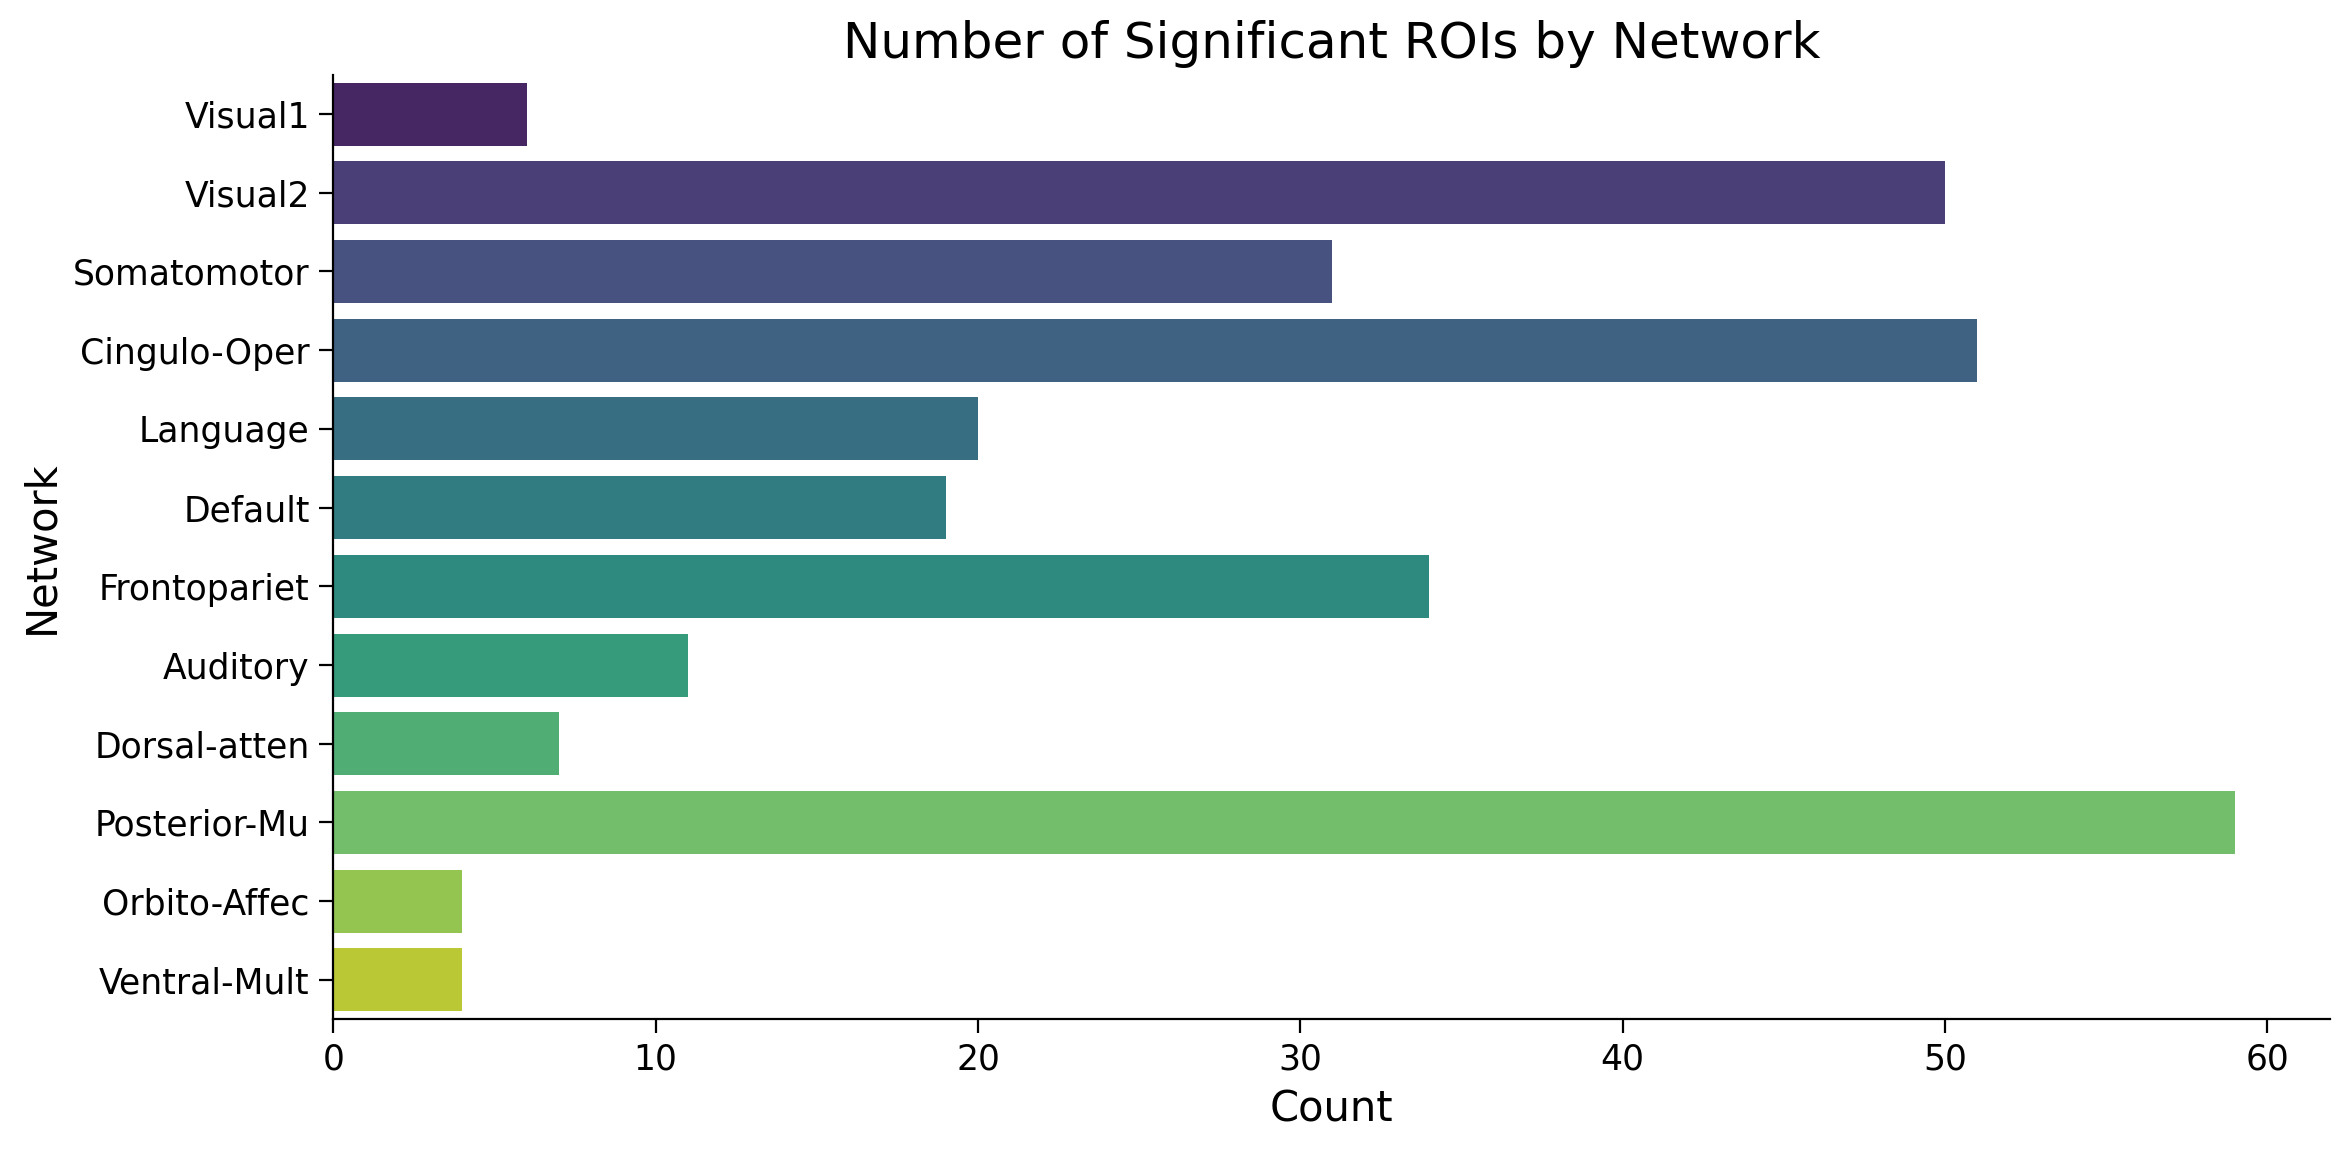

<ipython-input-12-c99dfe309876>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




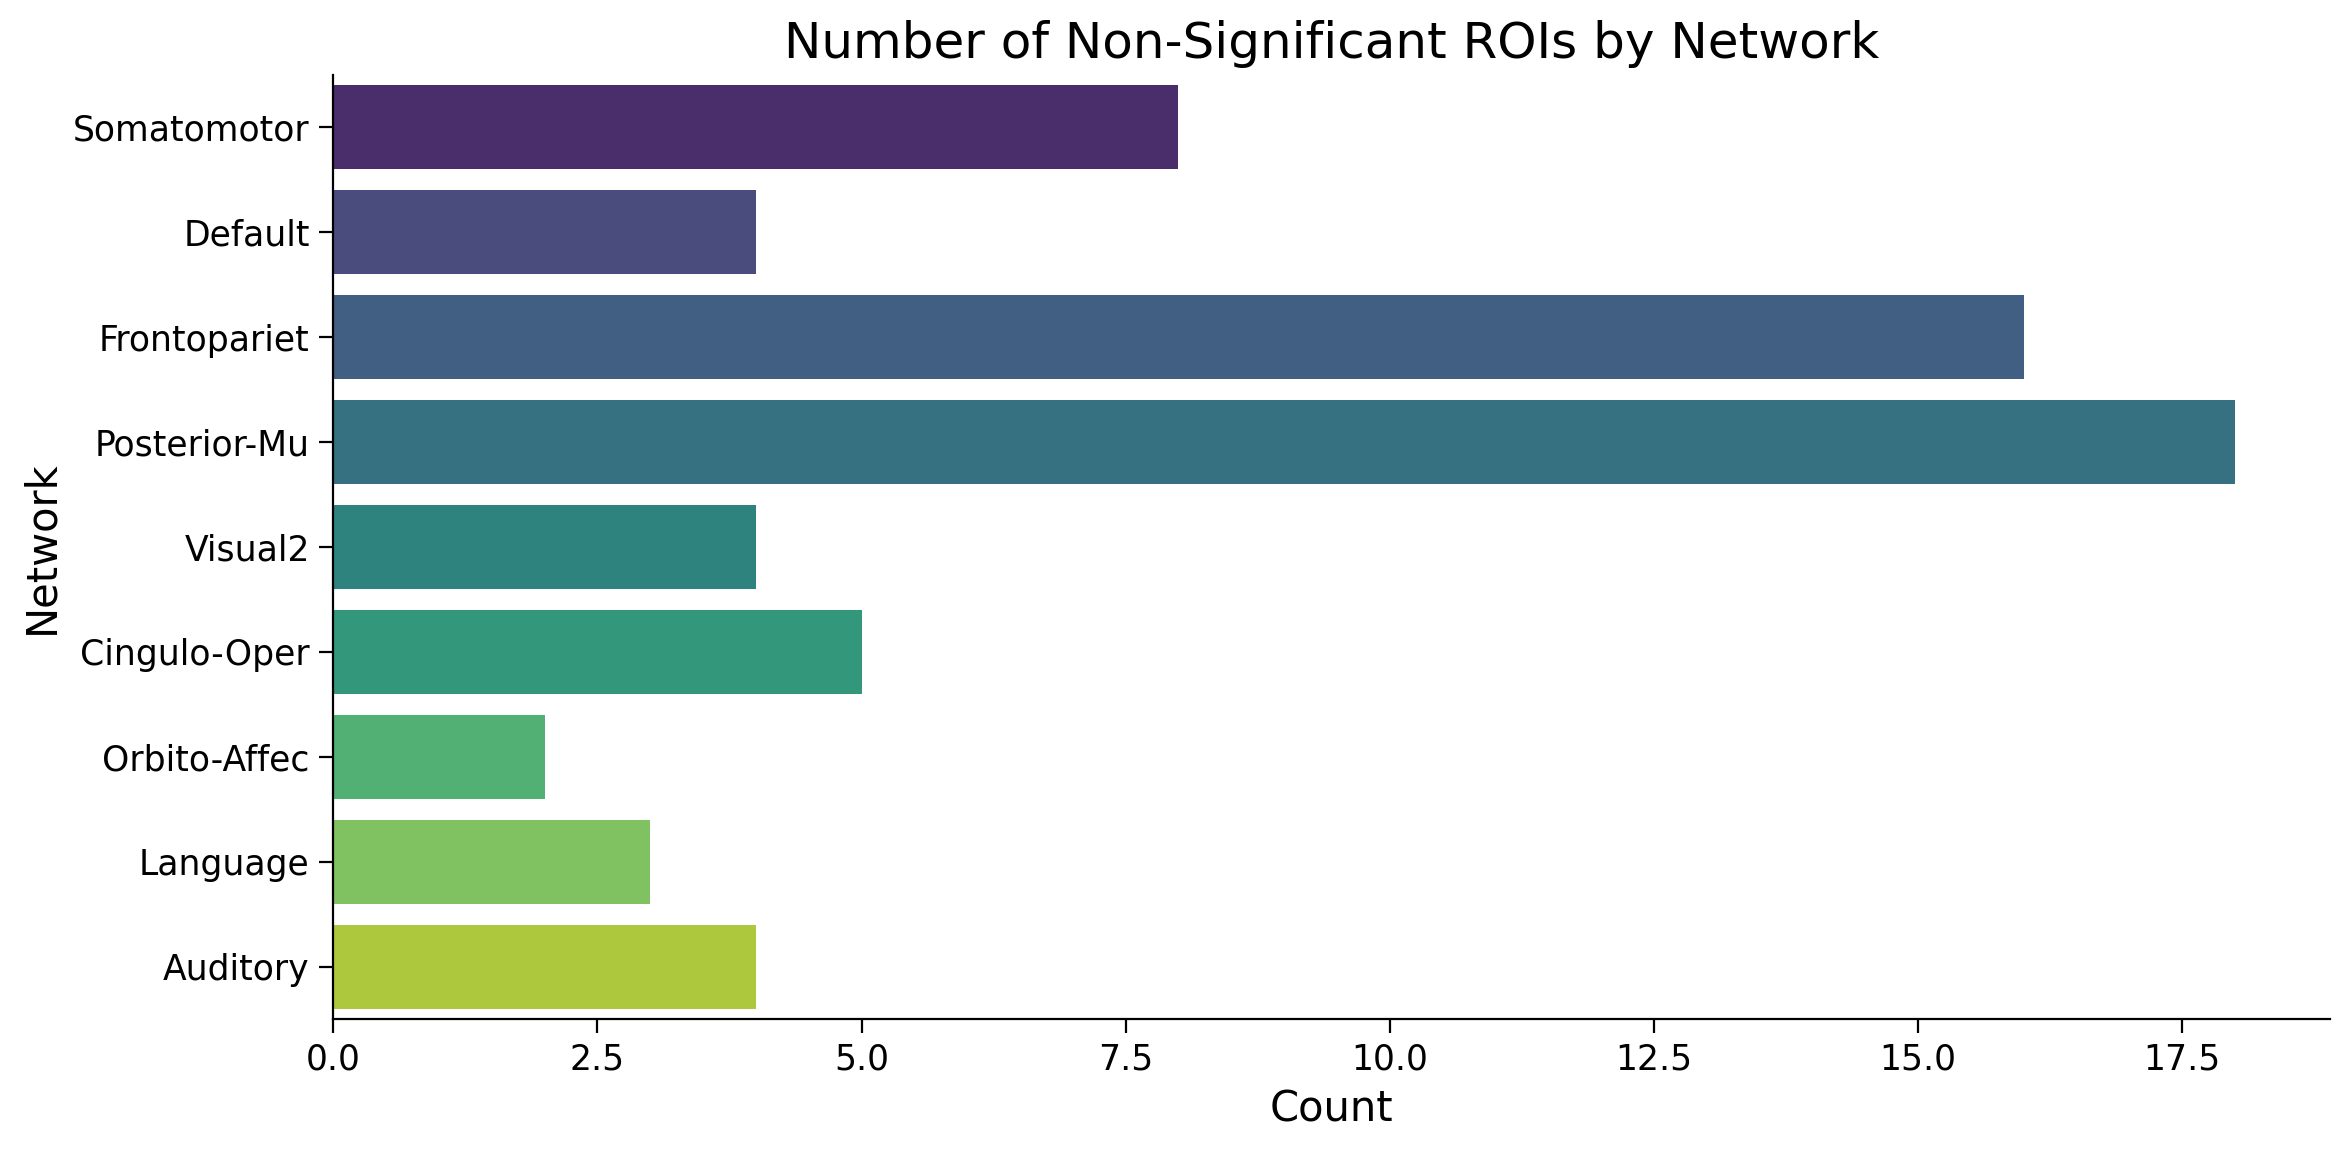

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load region data from numpy file
regions = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
roi_names = regions[0].tolist()
roi_networks = regions[1]

# Use the p-values to determine significance
significant_mask = p_values < significance_threshold

# Prepare data for plotting
df_roi = pd.DataFrame({
    'ROI': roi_names,
    'Network': roi_networks,
    'p-value': p_values,
    'Significant': significant_mask
})

# Filter for significant ROIs
df_significant = df_roi[df_roi['Significant']]

# Plotting significant ROIs by network
plt.figure(figsize=(12, 6))
sns.countplot(data=df_significant, y='Network', palette='viridis')
plt.title('Number of Significant ROIs by Network')
plt.xlabel('Count')
plt.ylabel('Network')
plt.show()

# Optionally, plot non-significant ROIs for comparison
df_non_significant = df_roi[~df_roi['Significant']]
plt.figure(figsize=(12, 6))
sns.countplot(data=df_non_significant, y='Network', palette='viridis')
plt.title('Number of Non-Significant ROIs by Network')
plt.xlabel('Count')
plt.ylabel('Network')
plt.show()

**CONCLUSION:** EMOTION experiment demonstrates that the brain's response to 'fear' and 'neut' conditions involves distinct patterns of activity, with significant differences observed in specific ROIs and networks. This suggests that the brain processes these emotional conditions differently, which is consistent with our understanding of emotional processing in the brain.



**--------------------------- Models Training and Testing -----------------------**



### **SVM Model**

In [ ]:
# @title Data Preparation and Model Training

experiment = 'EMOTION'

# Collect all features and labels across subjects and runs
X_all = []
y_all = []

for subject in range(N_SUBJECTS):
    # Load data for both runs
    data_run1 = load_single_timeseries(subject=subject, experiment=experiment, run=0, dir=os.path.join(HCP_DIR, "hcp_task"))
    data_run2 = load_single_timeseries(subject=subject, experiment=experiment, run=1, dir=os.path.join(HCP_DIR, "hcp_task"))

    # Load EVs for both runs
    evs_run1 = load_evs(subject=subject, experiment=experiment, run=0, dir=os.path.join(HCP_DIR, "hcp_task"))
    evs_run2 = load_evs(subject=subject, experiment=experiment, run=1, dir=os.path.join(HCP_DIR, "hcp_task"))

    # Extract features for both runs
    Fear_run1 = average_frames(data_run1, evs_run1, experiment, 'fear')
    Neut_run1 = average_frames(data_run1, evs_run1, experiment, 'neut')
    Fear_run2 = average_frames(data_run2, evs_run2, experiment, 'fear')
    Neut_run2 = average_frames(data_run2, evs_run2, experiment, 'neut')

    # Ensure the shapes are consistent before concatenation
    if Fear_run1.shape == Neut_run1.shape == Fear_run2.shape == Neut_run2.shape == (360,):
        # Combine data from both runs
        Fear = np.vstack([Fear_run1, Fear_run2]).T  # Transpose to get (n_samples, n_features)
        Neut = np.vstack([Neut_run1, Neut_run2]).T  # Transpose to get (n_samples, n_features)

        # Create labels
        labels_fear = np.ones(Fear.shape[0])
        labels_neut = np.zeros(Neut.shape[0])
        X = np.vstack((Fear, Neut))
        y = np.hstack((labels_fear, labels_neut))

        # Append to all data
        X_all.append(X)
        y_all.append(y)

    else:
        print(f"Skipping subject {subject} due to mismatch in feature shapes.")

# Concatenate all subjects' data
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Check the shapes of X_all and y_all
print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

# Scale the features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Train SVM model using liblinear for optimization with increased iterations
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

X_all shape: (244080, 2)
y_all shape: (244080,)
SVM Accuracy: 0.5397615535889873


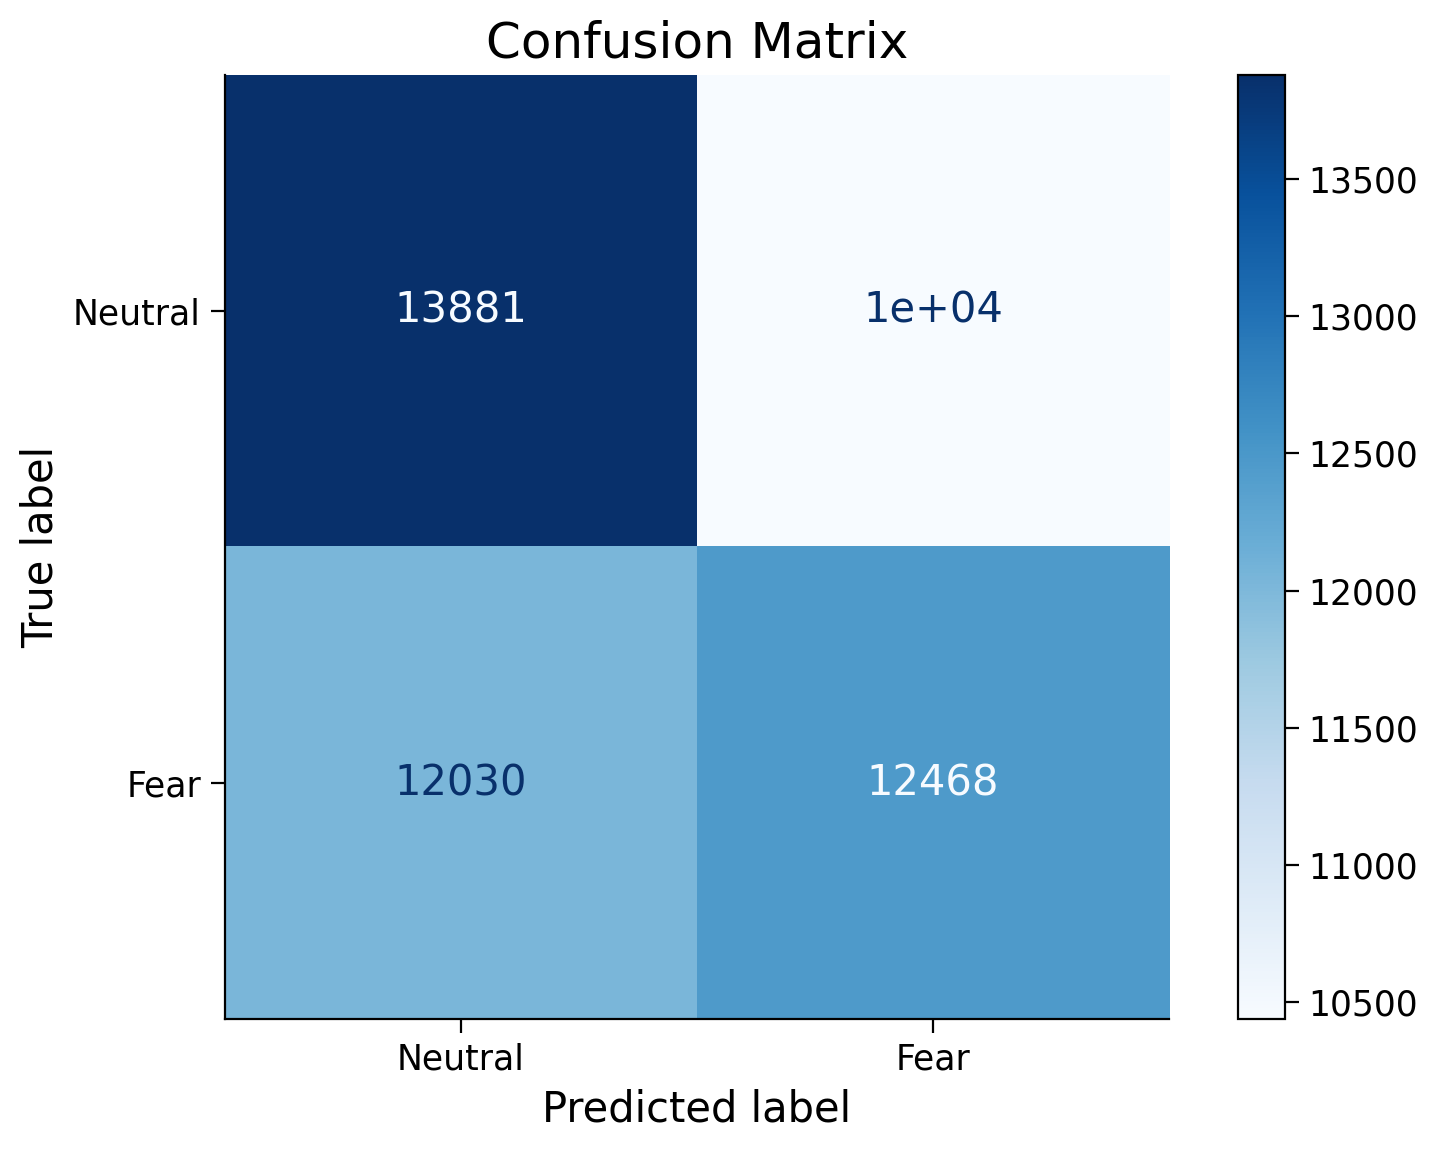

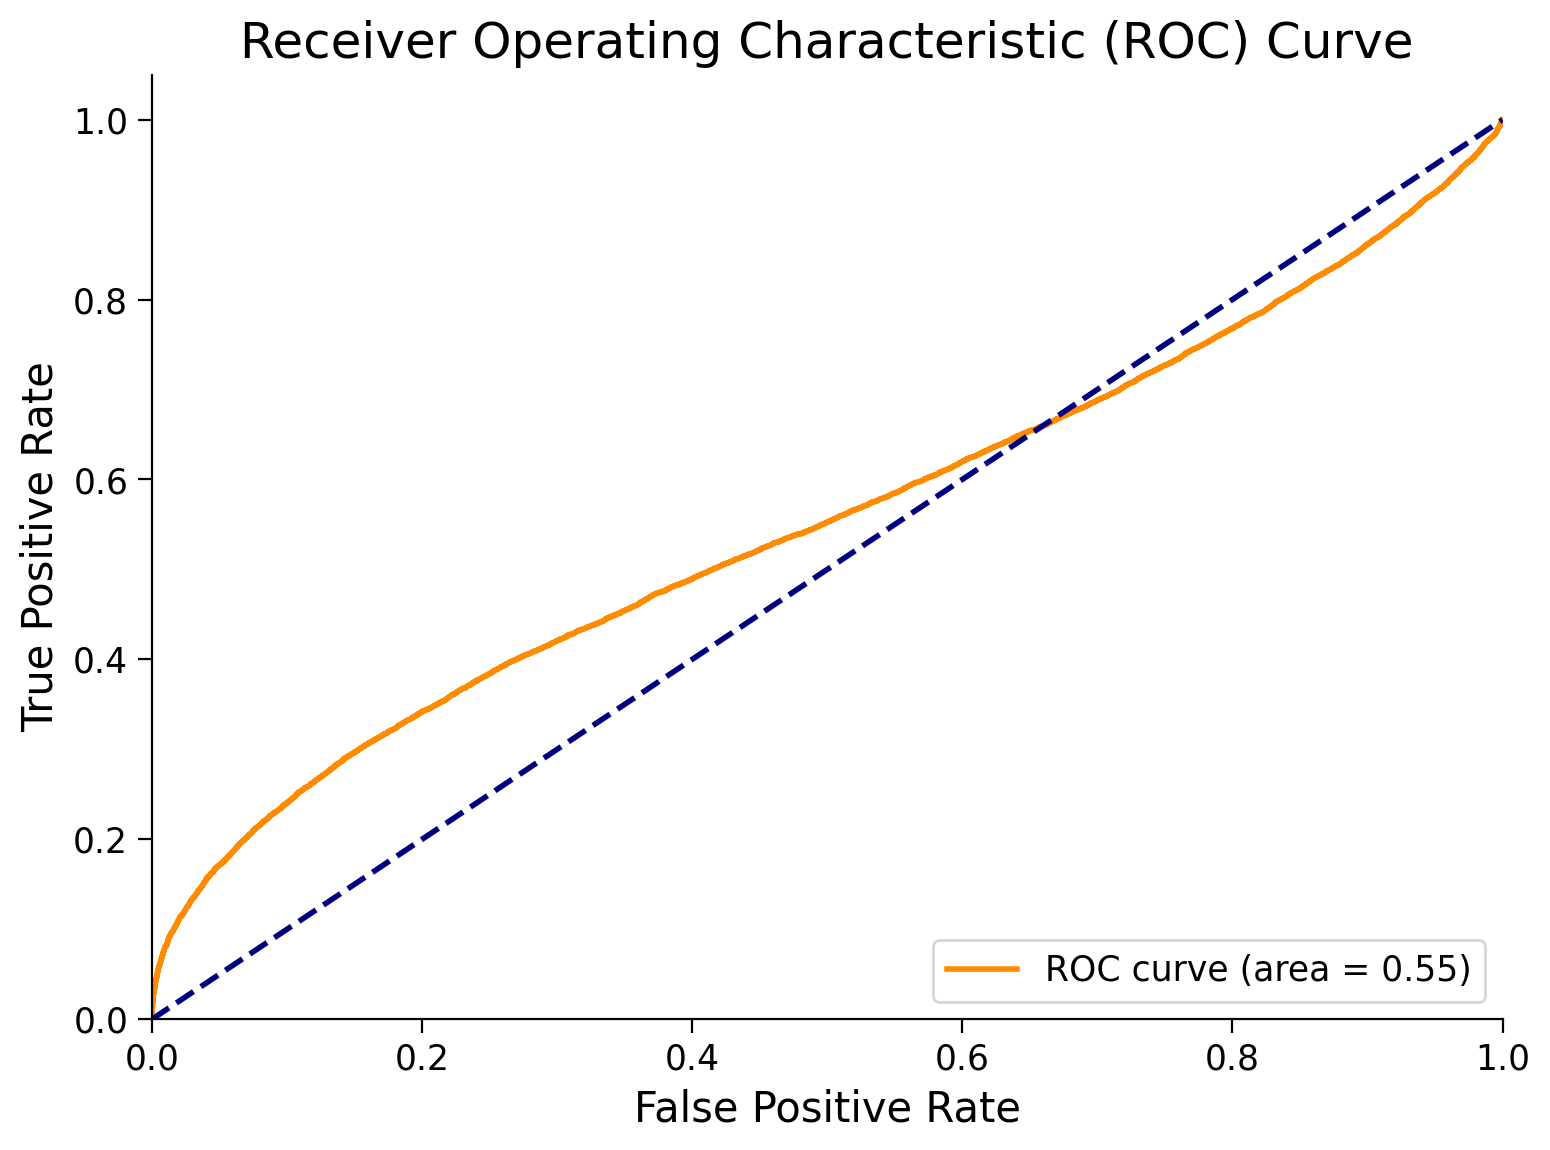

In [ ]:
# @title  SVM Model Evaluation

# Visualizing the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Fear'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Visualizing the ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC curve
y_pred_prob = svm_model.decision_function(X_test)
plot_roc_curve(y_test, y_pred_prob)



**----------------------------------------------------------------------Now to the GCN Model-------------------------------------------------------------------**





### **Graphical Neural Network (GNN) Model**

In [ ]:
## IMPORTANT TO SET: MPS FLAG
use_mps = True

# Check for device support
if use_mps and torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Print the device being used
print(f'Using device: {device}')

Using device: cpu


In [8]:
# @title GCN Architecture

class GCN_4layers_tunning(nn.Module):
    def __init__(self, n_features, n_channels, dropout, fc1_out, fc2_out):
        super(GCN_4layers_tunning, self).__init__()
        self.conv1 = pyg_nn.GCNConv(n_features, n_channels)
        self.conv2 = pyg_nn.GCNConv(n_channels, n_channels)
        self.conv3 = pyg_nn.GCNConv(n_channels, n_channels)
        self.conv4 = pyg_nn.GCNConv(n_channels, n_channels)
        self.fc1 = nn.Linear(n_channels, fc1_out)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, 2)  # Output layer for classification
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, self.dropout, self.training)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, self.dropout, self.training)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, self.dropout, self.training)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = pyg_nn.global_mean_pool(x, data.batch)  # Aggregate node features
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)  # Output logits
        return x

In [ ]:
# Explore the shape of the one aspect of the data, for example the fear
print("Shape of avg_activity_fear:", avg_activity_fear.shape)

# Explore
if avg_activity_fear.ndim == 1:
    num_nodes = avg_activity_fear.shape[0]
    num_features = 1  # Assuming 1 feature per node if the data is 1D
elif avg_activity_fear.ndim == 2:
    num_nodes, num_features = avg_activity_fear.shape
else:
    raise ValueError("Unexpected number of dimensions in avg_activity_fear")

print(f"Number of nodes (ROIs): {num_nodes}")
print(f"Number of features per node: {num_features}")

Shape of avg_activity_fear: (360,)
Number of nodes (ROIs): 360
Number of features per node: 1


**Our** "prepare_graph_data" **function below does the following:**

*   -Converts the 1D array avg_activity to a 2D tensor with shape [num_nodes,
num_features].
*   -Constructs a simple ring graph for the edges.
*   -Prepares the labels in the correct format.

**This preparation aligns with the requirements for a GCN wher**e:

* -x should be a tensor of shape [num_nodes, num_features].
* -edge_index should be a tensor of shape [2, num_edges].
* -y should be a tensor of shape [1] for a single graph.

In [ ]:
# @title Data Reformating and Graph construction

# Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
# Print the device being used
print(f'Using device: {device}')

def prepare_graph_data(avg_activity, label):
    num_nodes = avg_activity.shape[0]  # Should be 360 as we have 360 ROI
    num_features = 1  # Should be 1 as we have one feature (average activity) per node/ROI

    # Create a ring graph as we do not have functional connectivity informtaion/matrix in our data
    edge_index = torch.tensor([
        list(range(num_nodes - 1)) + [num_nodes - 1],
        list(range(1, num_nodes)) + [0]
    ], dtype=torch.long).to(device)  # Shape: [2, num_edges]

    # Convert avg_activity to a tensor and ensure it's shaped correctly
    x = torch.tensor(avg_activity, dtype=torch.float).unsqueeze(-1).to(device)  # Convert to [num_nodes, num_features]
    y = torch.tensor([label], dtype=torch.long).to(device)  # Single label for the graph
    return Data(x=x, edge_index=edge_index, y=y)

# Prepare data for all subjects and runs
SUBJECTS = list(range(339))  # Subjects from 0 to 338
RUNS = [0, 1]
data_list = []
for subject in SUBJECTS:
    for run in RUNS:
        data = load_single_timeseries(subject=subject, experiment='EMOTION', run=run, dir=os.path.join(HCP_DIR, "hcp_task"), remove_mean=True)
        evs = load_evs(subject=subject, experiment='EMOTION', run=run, dir=os.path.join(HCP_DIR, "hcp_task"))
        avg_activity_fear = average_frames(data, evs, 'EMOTION', 'fear')
        avg_activity_neutral = average_frames(data, evs, 'EMOTION', 'neut')
        fear_graph_data = prepare_graph_data(avg_activity_fear, label=0)  # Assuming 'fear' is label 0
        neutral_graph_data = prepare_graph_data(avg_activity_neutral, label=1)  # Assuming 'neutral' is label 1
        data_list.extend([fear_graph_data, neutral_graph_data])

# Create DataLoader with all graphs
#data_loader = DataLoader(data_list, batch_size=1)

def create_dataloader(X, y, indices):
    data_list = []
    for i in indices:
        avg_activity = X[i]
        label = y[i]
        graph_data = prepare_graph_data(avg_activity, label)
        data_list.append(graph_data)
    return DataLoader(data_list, batch_size=1, shuffle=True)

# Convert collected data to tensors
#X_all = [data.x.squeeze().to(device).to('cpu').numpy() for data in data_list]
#y_all = [data.y.item() for data in data_list]

# Convert collected data to tensors  RECOMMENDED
X_all = [data.x.squeeze().to(device).cpu().numpy() for data in data_list]
y_all = [data.y.item() for data in data_list]

# Generate train and test indices
all_indices = np.arange(len(X_all))
train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=y_all)

# Create DataLoaders
train_loader = create_dataloader(X_all, y_all, train_indices)
test_loader = create_dataloader(X_all, y_all, test_indices)

Using device: cpu


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [ ]:
# Check the shape of the first element in X_all
if len(X_all) > 0:
    example_shape = X_all[0].shape
    num_graphs = len(X_all)
    print(f'Shape of each element in X_all: {example_shape}')
    print(f'Number of elements in X_all: {num_graphs}')
else:
    print('X_all is empty')

# Check the number of labels in y_all
num_labels = len(y_all)
print(f'Number of elements in y_all: {num_labels}')

Shape of each element in X_all: (360,)
Number of elements in X_all: 1356
Number of elements in y_all: 1356


In [ ]:
# @title Model Intialization and Training

# Initialize the model
model = GCN_4layers_tunning(n_features=1, n_channels=16, dropout=0.5, fc1_out=64, fc2_out=32)
#model = GCN_4layers_tunning(n_features=1, n_channels=64, dropout=0.5, fc1_out=32, fc2_out=16)
model.to(device)  # Move model to GPU if available

# Train function
def train(data_loader, epochs):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for data in data_loader:
            data = data.to(device)  # Move data to GPU if available
            optimizer.zero_grad()
            output = model(data)  # Pass the Data object
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


# Train GCN model
train(train_loader, epochs=100)

Epoch 1/100, Loss: 0.7097442150115967
Epoch 2/100, Loss: 0.8152103424072266
Epoch 3/100, Loss: 0.43832841515541077
Epoch 4/100, Loss: 1.0973492860794067
Epoch 5/100, Loss: 0.3368789851665497
Epoch 6/100, Loss: 0.21874096989631653
Epoch 7/100, Loss: 0.26412394642829895
Epoch 8/100, Loss: 0.18366220593452454
Epoch 9/100, Loss: 0.18513396382331848
Epoch 10/100, Loss: 0.17666395008563995
Epoch 11/100, Loss: 0.26413702964782715
Epoch 12/100, Loss: 0.07618989795446396
Epoch 13/100, Loss: 0.5555418729782104
Epoch 14/100, Loss: 0.1696574091911316
Epoch 15/100, Loss: 2.85235333442688
Epoch 16/100, Loss: 0.0010676642414182425
Epoch 17/100, Loss: 0.03746423497796059
Epoch 18/100, Loss: 0.1610773503780365
Epoch 19/100, Loss: 0.011428368277847767
Epoch 20/100, Loss: 0.25150325894355774
Epoch 21/100, Loss: 0.06354890763759613
Epoch 22/100, Loss: 0.47410741448402405
Epoch 23/100, Loss: 0.16506311297416687
Epoch 24/100, Loss: 0.19769476354122162
Epoch 25/100, Loss: 0.17004819214344025
Epoch 26/100, Lo

Accuracy: 0.7757
Precision: 0.7908
Recall: 0.7757
F1 Score: 0.7728
Confusion Matrix:
[[ 90  46]
 [ 15 121]]


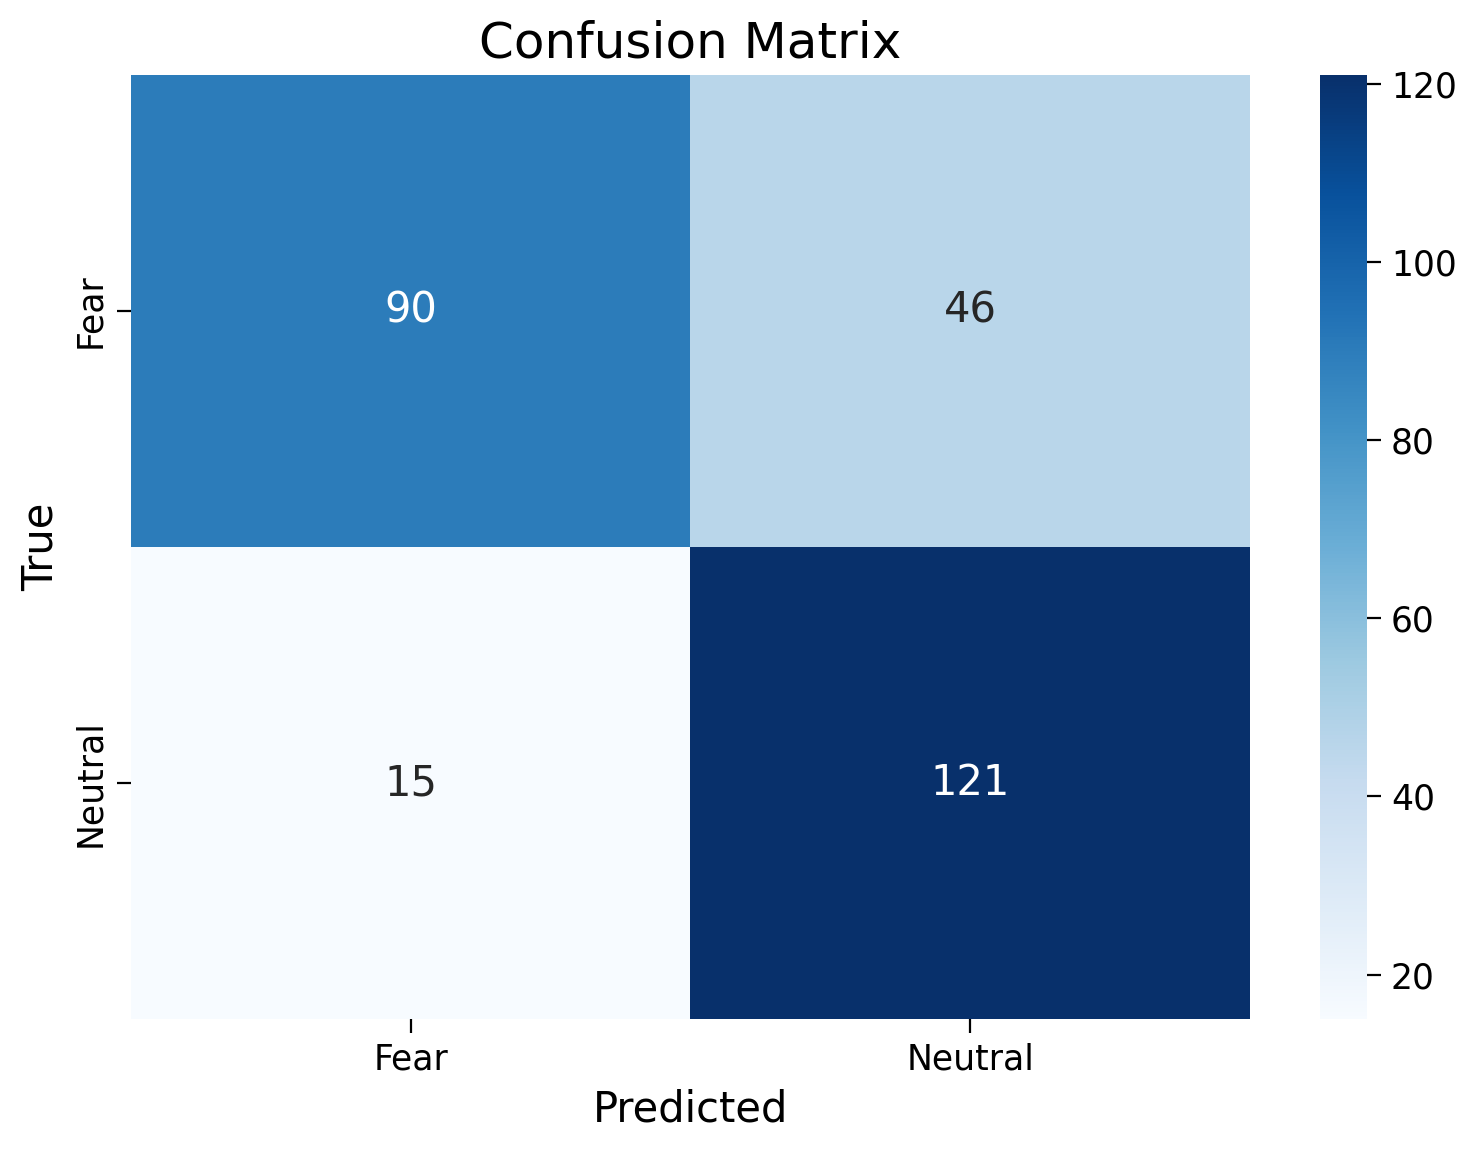

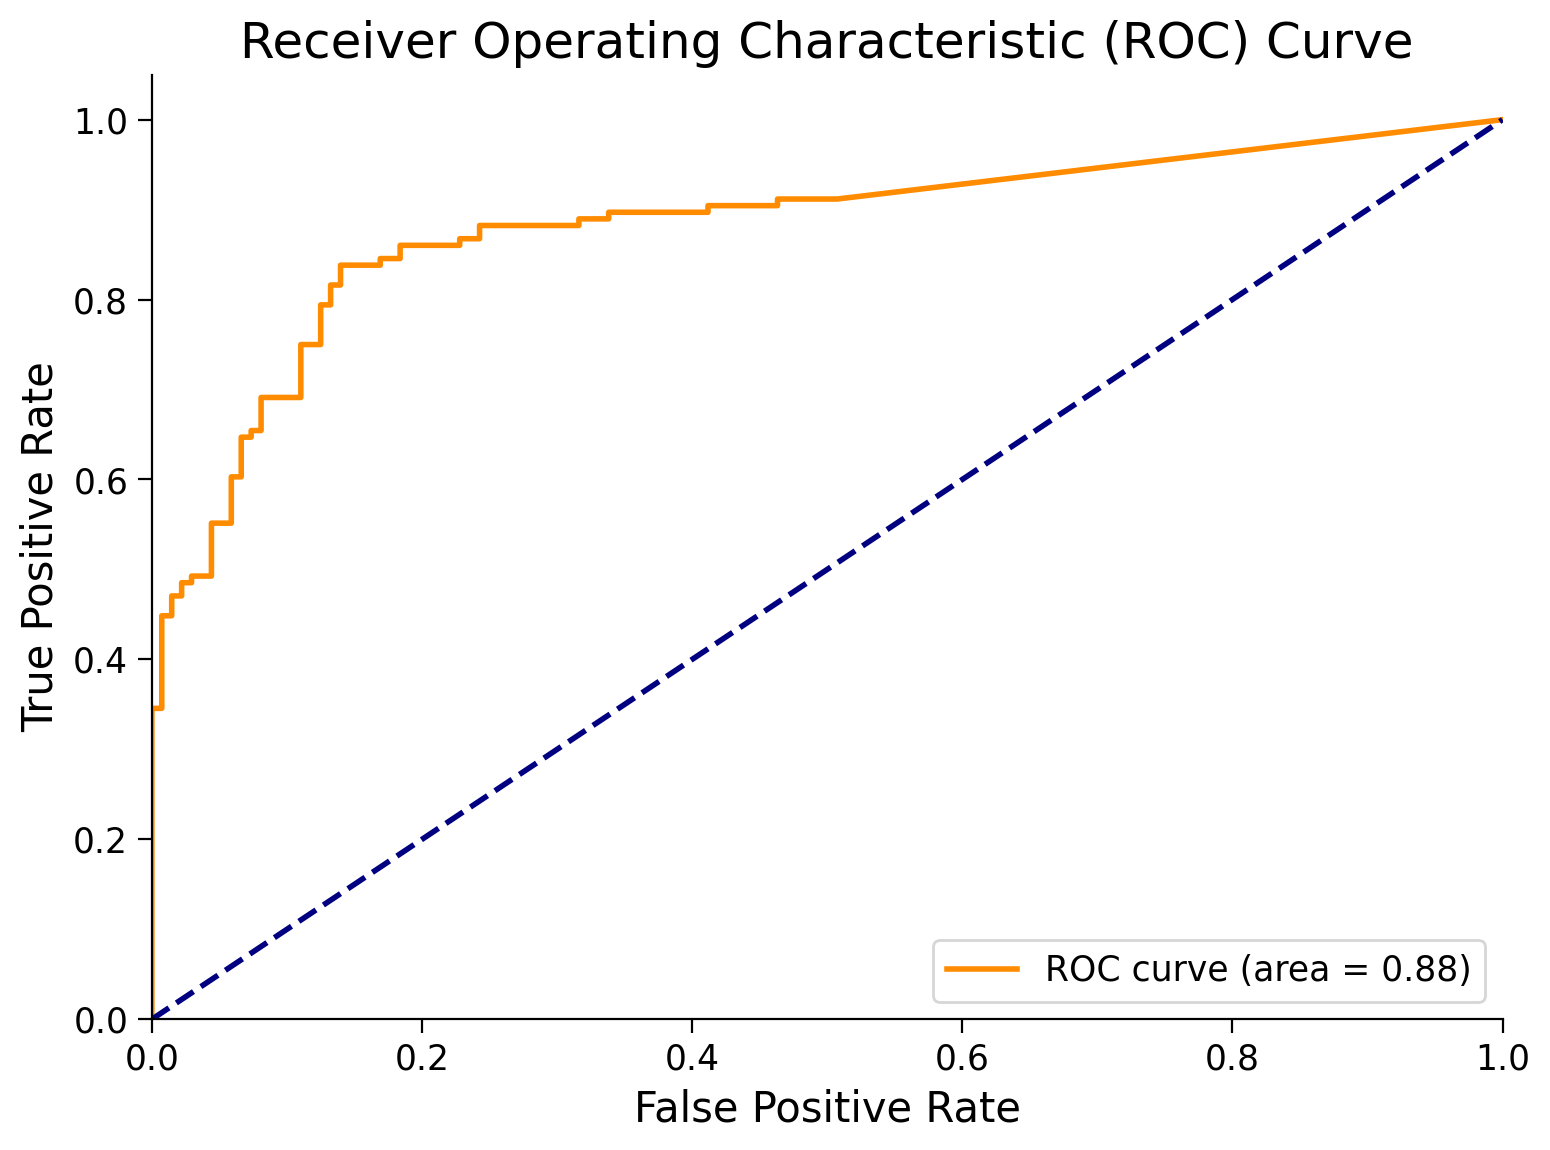

In [ ]:
# @title GCN Model evaluation

# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


# Evaluation function
def evaluate(data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []  # To store probabilities for ROC curve

    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Move data to GPU if available
            output = model(data)
            probs = torch.softmax(output, dim=1)  # Convert logits to probabilities
            _, predicted = torch.max(output, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')

    # Plot confusion matrix
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fear', 'Neutral'], yticklabels=['Fear', 'Neutral'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Assuming binary classification, modify if multiclass
    plot_roc_curve(all_labels, all_probs[:, 1])

# Evaluate the model
evaluate(test_loader)

**------------------ END OF PROJECT ✌ ----------------**

## **Appendix**

In [11]:
# This installation takes around 30 minutes to finish... Be patient!
!pip install torch torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric torchviz --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=507268 sha256=ed00239b77489fc992e1720a8d007b5d4806323ebfe079c873c7253ca881a450
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1092566 sha256=11a917561535d6b3cd0399ecf6a201a993ad58f2244d16d0a1274f600e078ea6
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
  Created wheel for torc

In [67]:
# @title Detailed Sketch of the GCN Architecture

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import torchviz

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualization part
n_features = 16
n_channels = 64
dropout = 0.5
fc1_out = 32
fc2_out = 16
model = GCN_4layers_tunning(n_features, n_channels, dropout, fc1_out, fc2_out).to(device)

# Create a dummy Data object
dummy_data = Data(
    x=torch.randn(10, n_features).to(device),  # 10 nodes with feature dimension of 16
    edge_index=torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [1, 0, 3, 2, 5, 4, 7, 6, 9, 8]]).to(device),  # 10 edges
    batch=torch.tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]).to(device)  # Batch size of 2 (5 nodes each)
)

# Make a forward pass to visualize
dummy_data = dummy_data.to(device)
output = model(dummy_data)

# Visualize the architecture using torchviz
dot = torchviz.make_dot(output, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('GCN_4layers_tunning')

from IPython.display import Image
Image(filename='GCN_4layers_tunning.png')

from google.colab import files
files.download('GCN_4layers_tunning.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

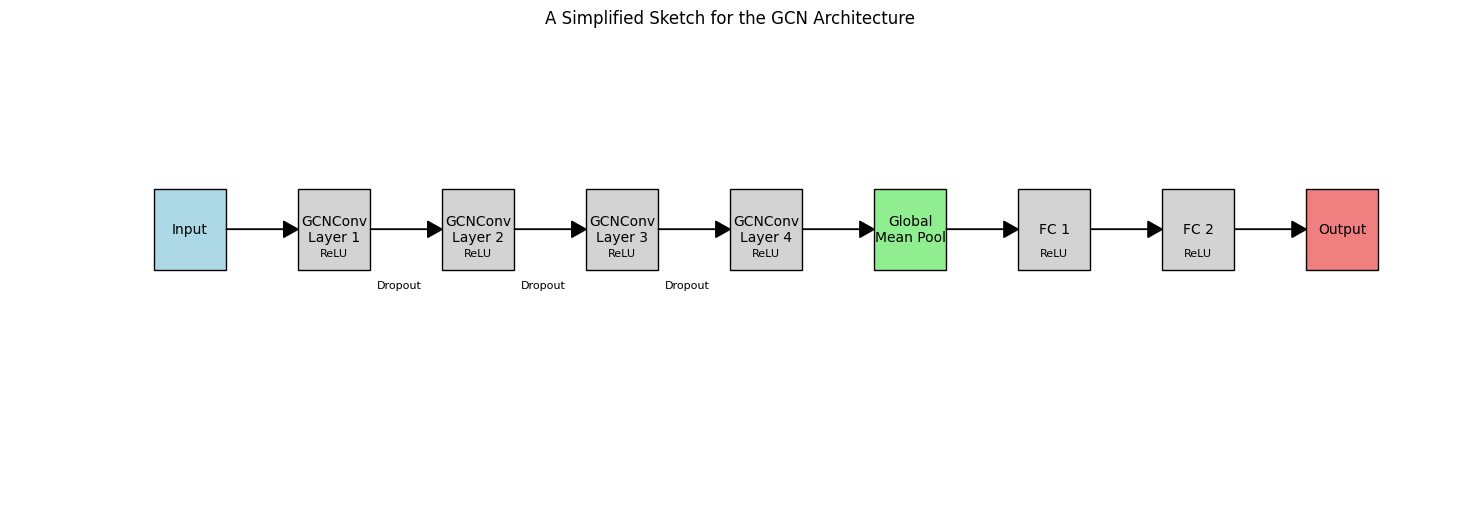

In [66]:
# @title Simplified Sketch of the GCN Architecture

import matplotlib.patches as patches

# Function to create the architecture diagram
def draw_gcn_architecture():
    fig, ax = plt.subplots(figsize=(15, 6))

    # Define layer positions
    layer_positions = [
        (0, 1.5),  # Input
        (1, 1.5),  # GCNConv 1
        (2, 1.5),  # GCNConv 2
        (3, 1.5),  # GCNConv 3
        (4, 1.5),  # GCNConv 4
        (5, 1.5),  # Global Mean Pool
        (6, 1.5),  # Fully Connected 1
        (7, 1.5),  # Fully Connected 2
        (8, 1.5)   # Output
    ]

    # Draw layers
    for (i, (x, y)) in enumerate(layer_positions):
        if i == 0:
            ax.add_patch(patches.Rectangle((x, y), 0.5, 0.5, fill=True, edgecolor='black', facecolor='lightblue'))
            ax.text(x + 0.25, y + 0.25, 'Input', ha='center', va='center')
        elif i == 5:
            ax.add_patch(patches.Rectangle((x, y), 0.5, 0.5, fill=True, edgecolor='black', facecolor='lightgreen'))
            ax.text(x + 0.25, y + 0.25, 'Global\nMean Pool', ha='center', va='center')
        elif i == 6:
            ax.add_patch(patches.Rectangle((x, y), 0.5, 0.5, fill=True, edgecolor='black', facecolor='lightgray'))
            ax.text(x + 0.25, y + 0.25, 'FC 1', ha='center', va='center')
            ax.text(x + 0.25, y + 0.1, 'ReLU', ha='center', va='center', fontsize=8, color='black')
        elif i == 7:
            ax.add_patch(patches.Rectangle((x, y), 0.5, 0.5, fill=True, edgecolor='black', facecolor='lightgray'))
            ax.text(x + 0.25, y + 0.25, 'FC 2', ha='center', va='center')
            ax.text(x + 0.25, y + 0.1, 'ReLU', ha='center', va='center', fontsize=8, color='black')
        elif i == 8:
            ax.add_patch(patches.Rectangle((x, y), 0.5, 0.5, fill=True, edgecolor='black', facecolor='lightcoral'))
            ax.text(x + 0.25, y + 0.25, 'Output', ha='center', va='center')
        else:
            ax.add_patch(patches.Rectangle((x, y), 0.5, 0.5, fill=True, edgecolor='black', facecolor='lightgray'))
            ax.text(x + 0.25, y + 0.25, f'GCNConv\nLayer {i}', ha='center', va='center')
            ax.text(x + 0.25, y + 0.1, 'ReLU', ha='center', va='center', fontsize=8, color='black')

    # Draw arrows
    for i in range(len(layer_positions) - 1):
        ax.arrow(layer_positions[i][0] + 0.5, layer_positions[i][1] + 0.25,
                 (layer_positions[i + 1][0] - layer_positions[i][0] - 0.5) * 0.8, 0,
                 head_width=0.1, head_length=0.1, fc='black', ec='black')

    # Draw dropout annotations with adjustable positioning
    dropout_positions = [1, 2, 3]  # Dropout after GCNConv 1, 2, and 3
    dropout_offsets = [0.3, 0.3, 0.3]  # Adjust these values to move dropout labels left/right

    for i, pos in enumerate(dropout_positions):
        x, y = layer_positions[pos]
        ax.text(x + 1 - dropout_offsets[i], y - 0.1, 'Dropout', ha='center', va='center', fontsize=8, color='black')

    # Adjust the space between the title and the sketch
    plt.title('A Simplified Sketch for the GCN Architecture', pad=0)  # Reduce padding further

    # Adjust subplot parameters for better layout
    plt.subplots_adjust(top=0.9)  # Bring title closer to plot

    # Use tight_layout to ensure no overlap
    plt.tight_layout(pad=1)  # Adjust padding as necessary

    ax.set_xlim(-1, 9)
    ax.set_ylim(0, 3)
    ax.axis('off')

    plt.show()

# Draw the updated architecture diagram
draw_gcn_architecture()


<ipython-input-39-c90e5a5a93dd>:41: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

<ipython-input-39-c90e5a5a93dd>:42: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



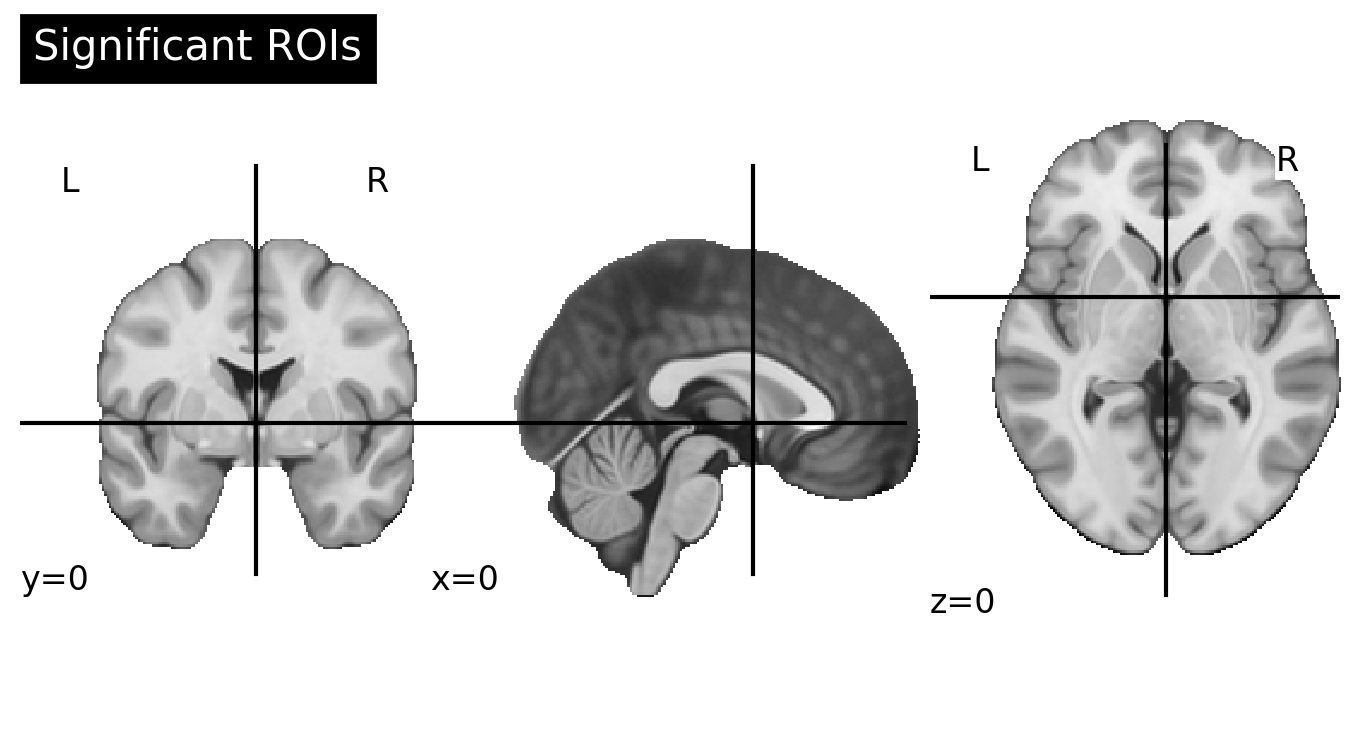

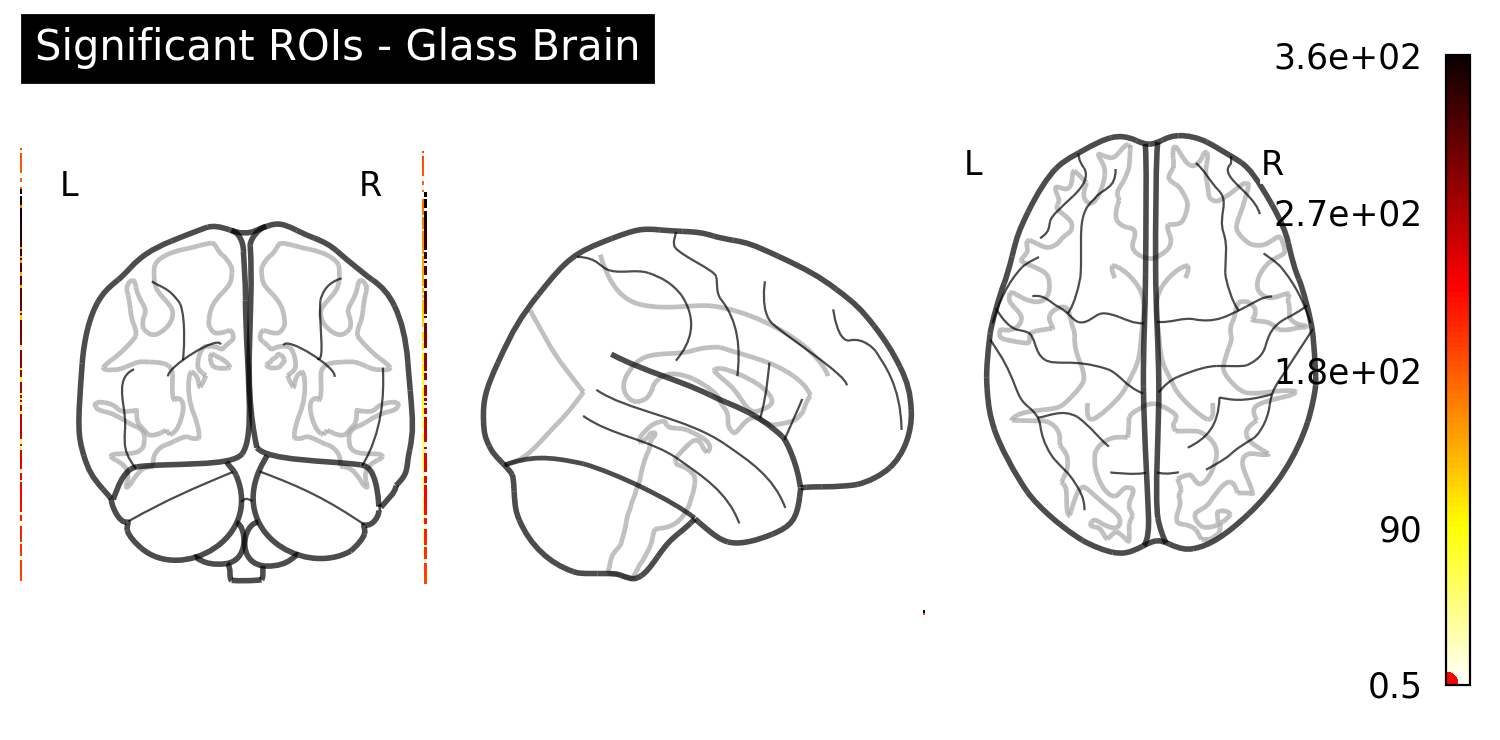

In [ ]:
# @title Glass brain (without ROIs)
from nilearn import plotting, image, datasets
from nilearn.image import new_img_like
from nilearn.plotting import plot_glass_brain, plot_img

# Load the standard brain template
brain_template = datasets.load_mni152_template()

# Initialize ROI map
roi_map = np.zeros(np.prod(brain_template.shape))  # Flattened ROI map

# Map significant ROIs
for idx, significance in enumerate(roi_data['Significant']):
    if significance:
        if idx < roi_map.size:
            roi_map[idx] = idx + 1  # Assign unique index value to significant ROIs

# Reshape to match brain template
roi_map_3d = roi_map.reshape(brain_template.shape)

# Create an NIfTI image from the ROI map
roi_img = new_img_like(brain_template, roi_map_3d)

# Plot the brain template with ROIs
plot_img(roi_img, bg_img=brain_template, title='Significant ROIs', display_mode='ortho', threshold=0.5, cut_coords=(0, 0, 0), cmap='Reds')

# Extract coordinates for significant ROIs
coords = [np.unravel_index(idx, brain_template.shape) for idx in range(len(p_values)) if roi_data['Significant'][idx]]

# Plotting significant coordinates on a glass brain for clarity
glass_brain_plot = plot_glass_brain(roi_img, display_mode='ortho', title='Significant ROIs - Glass Brain', colorbar=True, threshold=0.5)

# Add markers manually using matplotlib
for coord in coords:
    x, y, z = coord
    plt.scatter(x, y, color='red', s=50)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('roi_map_with_annotations.png')

# Show the plot
plt.show()

# **--------------------------------------------**